In [1]:
# import winsound
# import pyaudio as winsound
import os

import time

import datetime as dt
import urllib
import cdflib as cdf

import pickle

import scipy
import scipy.signal

import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline

from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.colors import LogNorm,Normalize

from collections import defaultdict
import pytplot
from pytplot import time_datetime
from pyspedas import time_string,time_double,tinterpol

import matplotlib.colors as colors

### Add functions from functions.ipynb, located in folder (str)
import sys as sys
if '/Users/sfordin/Documents/Science-Projects' not in sys.path:
    sys.path.append('/Users/sfordin/Documents/Science-Projects')
if '/Users/sfordin/Plotbot' not in sys.path:
    sys.path.append('/Users/sfordin/Plotbot')

from plotbot import *

import warnings

# import ipynb
# from ipynb.fs.defs.functions import (read_mfi,mfi_varsnip,read_3dp,thrdp_varsnip,read_swe,swe_varsnip,
#                                      read_solo_mag,read_solo_swa,solo_mag_varsnip,solo_swa_varsnip,
#                                      highpass,lowpass,bandpass,mva,chunk,resample,
#                                      padded_power,freqs_from_fft_peaks,mva_subintervals,wavelet_spec,boxcar_ave,Wavelet2Go)




🕒 Starting import timing session: plotbot_full_initialization
  ✅ matplotlib.pyplot: 0.000s
  ✅ numpy: 0.000s
  🔧 Starting block: core_components
initialized server_access
initialized global_tracker
initialized plot_config
initialized plot_manager
initialized epad class
initialized epad_hr class
initialized proton class
initialized proton_hr class
initialized ham_class
initialized psp_alpha class
initialized psp_qtn class
initialized psp_orbit class
initialized psp_span_vdf class
initialized data_cubby.
CDF classes added to data_cubby type map.
  ✅ Block 'core_components' completed in 0.247s
  🔧 Starting block: psp_data_classes
initialized proton_fits class
initialized alpha_fits class
  ✅ Block 'psp_data_classes' completed in 0.002s
  🔧 Starting block: wind_data_classes
  ✅ Block 'wind_data_classes' completed in 0.000s
  🔧 Starting block: data_cubby_registration
  ✅ Block 'data_cubby_registration' completed in 0.001s
  🔧 Starting block: auto_register_custom_classes
  ✅ Block 'auto_re

In [2]:
# !pip install numba

In [3]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.family': 'Times New Roman'})

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.05


In [4]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [5]:
###############################################
### COMPUTE WAVELET TRANSFORM ON LONG INTERVALS
###############################################

## B : array-like (Nx3); 
##     use np.vstack for correct shape

## V,T,np : 0 or array-like
##         cadence of V,T,np should match that of B when given to wavelet2Long

## delta_t : instrument cadence


def wavelet2Long(t_range,B,V=0,T=0,n_p=0,delta_t = 1/16,f_n = 128,f_min = 1e-3,f_max=8,percent_COI=0.2):

    ## 0. Initialize B,V,T,n
    
    ## B    
    df = pd.DataFrame(data=np.vstack((B[0][t_range[0]:t_range[1]],B[1][t_range[0]:t_range[1]],B[2][t_range[0]:t_range[1]])).T,columns=['Bx','By','Bz'])
    if df['Bx'].isna().sum()/len(df.Bx)<=0.1 and df['By'].isna().sum()/len(df.By)<=0.1 and df['Bz'].isna().sum()/len(df.Bz)<=0.1 :
        df=df.interpolate()
        df=df.dropna()

        mu_0 = 4*np.pi*1e-7#N/A^2=kg.m/(s^2.A^2)
        m_proton=1.673*1e-27#kg
        
        if n_p is 0:
            rho = 7*m_proton*1e6*5/6 # kg m^{-3} see Good et al. 2022 MNRAS for more details
        else:
            rho = m_proton * n_p
        # playing around with random values
        if V is 0:
            vx_n = np.repeat(400*1e3,df.Bx.shape[0]) # m/s
            vy_n = np.repeat(30*1e3,df.Bx.shape[0]) # m/s
            vz_n = np.repeat(-40*1e3,df.Bx.shape[0]) # m/s

        else:
            vx_n = V[0][t_range[0]:t_range[1]]
            vy_n = V[1][t_range[0]:t_range[1]]
            vz_n = V[2][t_range[0]:t_range[1]]

            z_plusx = vx_n+bx_n
            z_plusy = vy_n+by_n
            z_plusz = vz_n+bz_n

            z_minusx=vx_n-bx_n
            z_minusy=vy_n-by_n
            z_minusz=vz_n-bz_n
            
        bx_n = (1e-9*df.Bx)/np.sqrt(mu_0*rho) # m/s
        by_n = (1e-9*df.By)/np.sqrt(mu_0*rho) # m/s
        bz_n = (1e-9*df.Bz)/np.sqrt(mu_0*rho) # m/s
        
        radi=180/(4*np.arctan(1))
        ph=radi*np.arctan2(df.By,df.Bx)
        gg=np.where((ph < 0)); 
        for i in gg:
            ph[i]=radi*np.arctan2(df.By[i],df.Bx[i])+360.
        
        #select the inertial range (1e-4-1e-2 hz), dt=1min=60sec
        # print('uo')
        my_wavelet2go = Wavelet2Go(f_n=f_n, f_min=f_min, f_max=f_max, dt=delta_t) # Telloni et al 2020
        yticks,ytickfreqs = my_wavelet2go.get_y_ticks(reduction_to=5)
        xticks,xtickfreqs = my_wavelet2go.get_x_ticks(reduction_to=int(60*(60/delta_t)/2),data=df.Bx)
        cwtbfx, freqs = my_wavelet2go.perform_transform(df.Bx-np.mean(df.Bx))
        cwtbfy, freqs = my_wavelet2go.perform_transform(df.By-np.mean(df.By))
        cwtbfz, freqs = my_wavelet2go.perform_transform(df.Bz-np.mean(df.Bz))   

        eb_fluc = abs(cwtbfx)**2+abs(cwtbfy)**2+abs(cwtbfz)**2

        cwtbx, freqs = my_wavelet2go.perform_transform(df.Bx)
        cwtby, freqs = my_wavelet2go.perform_transform(df.By)
        cwtbz, freqs = my_wavelet2go.perform_transform(df.Bz)

        
        a=2*(np.conj(cwtby)*cwtbz).imag
        b=(abs(cwtby)**2+abs(cwtbz)**2)
        a=my_wavelet2go.mask_invalid_data(a, fill_value=0)
        b=my_wavelet2go.mask_invalid_data(b, fill_value=0)
        sigm = a/b                

        ## truncate time series based on cone of influence to avoid edge effects
        trunc_len = percent_COI * (t_range[1]-t_range[0])
        trunc_range = (int(t_range[0] + trunc_len),int(t_range[1]-trunc_len))
        # print('Complete:' + str(trunc_range) + ' from total length ' + str(B[0].size))
    return trunc_range,freqs,eb_fluc,sigm

26-Sep-25 14:51:02: <>:27: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?

26-Sep-25 14:51:02: <>:32: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?

26-Sep-25 14:51:02: <>:27: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?

26-Sep-25 14:51:02: <>:32: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?

26-Sep-25 14:51:02: /var/folders/3n/8nbttjbs573270nf5nvjg3cw0000gn/T/ipykernel_37586/4118305599.py:27: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if n_p is 0:

26-Sep-25 14:51:02: /var/folders/3n/8nbttjbs573270nf5nvjg3cw0000gn/T/ipykernel_37586/4118305599.py:32: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if V is 0:



In [6]:
### Zoom into phi_B and identify rotations in phi_B
def phinder(phi_B,strong_thresh = 135):
    
    
    o_flag = 1 # current orientation of phi_B; +/-1 corresponds to changing left/right bound
    double_fail = 0 # if double_fail > 1, return indices of magnetic field rotation
    
    l = 0
    r = phi_B.size

    while r - l > 1:
        
        ### define subinterval of contiguous interval with moving left bound
        sub_inds = [l,r]
        phi_B_int = phi_B[sub_inds[0]:sub_inds[1]]

        if o_flag > 0:
            phi_0_int = phi_B_int[0]
        elif o_flag < 0:
            phi_0_int = phi_B_int[-1]


        gamma = np.absolute(phi_B_int - phi_0_int)       # total angular difference
        chord = 2 * np.sin(np.deg2rad(gamma/2))          # length of chord on unit circle defined by gamma

        ang_diff = 2 * np.rad2deg(np.arcsin(chord/2))    # angle subtended by chord on unit circle defined by gamma 
        ang_diff_max = np.max(ang_diff)
            
        if ang_diff_max > strong_thresh:

            if o_flag > 0:
                r = l + np.where(ang_diff > strong_thresh)[0][0]

            elif o_flag < 0:
                l = l + np.where(ang_diff > strong_thresh)[0][-1]    
                
            rot_bounds = [l,r]
            double_fail = 0

            o_flag = -1 * o_flag
        
        if o_flag > 0:
            l += 1

        if o_flag < 0:
            r += 1

        if double_fail > 1:
            break
                      
    try:
        return rot_bounds
    except:
        return [np.nan,np.nan]


In [7]:
####################
### Autochordelation
####################
### Find indices associated with large rotations in phi_B with recursion
### Compute angles subtended by chords between points on unit circle given by phi_B_ds 
        # Loop 1: - Choose an interval and compute initial 
            # Loop 2: - Iterate through each angle and compute chord length relative to initial angle
            #         - If subtended angles satisfy criteria:
                # Loop 3: - Find shortest subinterval that satisfies the criteria 
                #         - Record final index of shortest subinterval and use as index of next initial angle
                #         - Record midpoint of shortest subinterval as single "time of rotation"
### Return indices of rotation bounds
### Return indices of rotation midpoints

def autochord(phi_B,strong_thresh = 135,weak_thresh = 90):
    

    j = 0
    rot_bounds = []
    num_empty = 0
    while j < phi_B.size:
        
        ### define subinterval iterating over the left bound
        phi_B_int = phi_B[j:] # interval of phi_B for autochordelation
        phi_0 = phi_B_int[0]         # initial phi_B to check against: first phi_B_median

        gamma = np.absolute(phi_B_int - phi_0)        # total angular difference
        chord = 2 * np.sin(np.deg2rad(gamma/2))       # length of chord on unit circle defined by gamma
        
        ang_diff = 2 * np.rad2deg(np.arcsin(chord/2)) # angle subtended by chord on unit circle defined by gamma
        ang_diff_max = np.max(ang_diff)               # index of maximum angular difference in contiguous interval

        if ang_diff_max > strong_thresh:
            
            # zoom into interval by moving left bound until failure, then right bound until failure, etc
            rot_inds = phinder(phi_B_int,strong_thresh=strong_thresh)

            rot_bounds.append([j + rot_inds[0] , j + rot_inds[1]])

            j += rot_inds[1] # update new position to last added right bound
        else:
            j += 1
            num_empty += 1

    rot_midpoints = [int(0.5*(rot_bounds[i][0]+rot_bounds[i][1])) for i in range(len(rot_bounds))]

    return rot_bounds,rot_midpoints


In [8]:
def dt2cal(dt):
    """
    Convert array of datetime64 to a calendar array of year, month, day, hour,
    minute, seconds, microsecond with these quantites indexed on the last axis.

    Parameters
    ----------
    dt : datetime64 array (...)
        numpy.ndarray of datetimes of arbitrary shape

    Returns
    -------
    cal : uint32 array (..., 7)
        calendar array with last axis representing year, month, day, hour,
        minute, second, microsecond
    """

    # allocate output 
    out = np.empty(dt.shape + (7,), dtype="u4")
    # decompose calendar floors
    Y, M, D, h, m, s = [dt.astype(f"M8[{x}]") for x in "YMDhms"]
    out[..., 0] = Y + 1970 # Gregorian Year
    out[..., 1] = (M - Y) + 1 # month
    out[..., 2] = (D - M) + 1 # dat
    out[..., 3] = (dt - D).astype("m8[h]") # hour
    out[..., 4] = (dt - h).astype("m8[m]") # minute
    out[..., 5] = (dt - m).astype("m8[s]") # second
    out[..., 6] = (dt - s).astype("m8[us]") # microsecond
    return out


In [9]:
### Get tasteful tick datetime display for a time array
    # Determines which unit should be used for the tick labels
    # ideally, this unit should be the largest one that changes between the tick labels and is easy to interpret

def tasteful_ticks(t,num_ticks = 6):


## 1. Compute total timedelta between first/last epochs
    t_dt64 = cdf.cdfepoch.to_datetime(t)

    # list of calendar units [Y,M,D,h,m,s,us]
    t_cal = dt2cal(t_dt64)


    tick_cal_list = np.array_split(t_cal,num_ticks)
    split_mid = int(tick_cal_list[0].shape[0]/2)
    tick_cal_list = [tick_cal_list[i][split_mid] for i in range(len(tick_cal_list))]
    tick_strf_list = [dt.datetime(year=tick_cal_list[i][0],month=tick_cal_list[i][1],day=tick_cal_list[i][2],
                                  hour=tick_cal_list[i][3],minute=tick_cal_list[i][4],second=tick_cal_list[i][5],
                                  microsecond=tick_cal_list[i][6]).strftime('%y/%m/%d %H:%M:%S.%f') for i in range(len(tick_cal_list))]

    # diff time in cal units between tick labels
    d_tick = [np.argmax(tick_cal_list[i+1] - tick_cal_list[i] > 0) for i in range(len(tick_cal_list) - 1)]

    # identify total number of changing labels and for each label 

    # units of change that are largest for more than 1 interval (i.e. the important changing units)
    d_tick_units_to_change = np.asarray(np.unique(d_tick,return_counts=True))
    d_tick_units_to_change = d_tick_units_to_change[0][np.where(d_tick_units_to_change[1] > 1)]


    # locations of ticks based on time array
    tick_locs = np.array_split(t,num_ticks)
    tick_locs = [tick_locs[i][split_mid] for i in range(len(tick_locs))]


    # for each t_cal to be referenced in ticks, identify the units to be used based on smallest unit and total number of units
    # hard code cases for multiple units of change
    if d_tick_units_to_change.size > 1:
        uoc = d_tick_units_to_change[-2]
    else:
        uoc = d_tick_units_to_change[0]

    # hard code strings
    if uoc == 0:
        tick_labels = [tick_strf_list[i][0:2] + '-' + tick_strf_list[i][3:5] for i in range(len(tick_cal_list))]
    elif uoc == 1:
        tick_labels = [tick_strf_list[i][3:5] + '-' + tick_strf_list[i][6:8] for i in range(len(tick_cal_list))]
    elif uoc == 2:
        tick_labels = [tick_strf_list[i][3:5] + '-' + tick_strf_list[i][6:8] for i in range(len(tick_cal_list))]
    elif uoc == 3:
        tick_labels = [tick_strf_list[i][9:11] + ':' + tick_strf_list[i][12:14] for i in range(len(tick_cal_list))]
    elif uoc == 4:
        tick_labels = [tick_strf_list[i][12:14] + ':' + tick_strf_list[i][13:15] for i in range(len(tick_cal_list))]
    elif uoc == 5:
        tick_labels = [tick_strf_list[i][13:15] + '.' + tick_strf_list[i][16:] for i in range(len(tick_cal_list))]


    

    return tick_locs,tick_labels


In [10]:
########################################################################
########################################################################

            ### HELIOSPHERIC CURRENT SHEET CROSSING AUTOMATION ###

########################################################################
########################################################################

def hcs_loc(tpad,tB,epad,phi_B,med_filter_len = 25, buffer_range = 1,parapar_rats = [1/3,3],beam_bg_rats = [2/3,3/2],return_bounds=False):

########################################################################
### QUESTIONS: 
########################################################################

### Basic HCS phenomenology:

# - Does strahl inversion "always" happen at 1 au for HCS crossings? 
        # Might we instead expect strahl dropout + reestablishment in the same direction on each side of hcs?

# - What constitutes a large change in the azimuth of B?
        # Adam Szabo: "135 degrees is typical"
        # Liou 2021: "120 degrees is the accepted degree of rotation"
        # Also Liou 2021: "Average is 137 degrees, but 30% of HCS crossings have < 120 degree field rotation" gaaaaaah how are these identified as HCS crossings


### Methodology:

# - Is it acceptable to directly compare counts in the first and last angular bins to establish strahl direction?
        # If so, what constitutes a "large" ratio of counts for unidirectionality? 1.5? 3? 10?
        # What are the widths of the pitch angle bins at each time step for EESA-Low? Can't find anywhere...

# - Can the prominence of the strahl be measured using the combined parallel/anti-parallel bin counts 
#   compared to sum of all counts in other bins?


########################################################################



### Davin's paper



########################################################################
### FIRST ATTEMPT: STEPS TO AUTOMATE DETECTION
########################################################################

### 1. Using strahl metrics, quantify interval types using flags (strong parallel, strong anti-parallel, weak and/or bi-directional strahl)

### 2. Using data flags, mark regions of changing strahl (where strahl changes from one type to another)

### 3. Within flagged regions, use phi_B metrics to quantify data types (large, moderate, small phi_B rotation)

### 4. Identify HCS crossing times using a final flag

########################################################################


# tpad: time array associated with epad
# tB: time array associated with phi_B
# epad: N x A x C array, where N is len(tpad), A is no. of solid angle bins, C is # energy channels
# phi_B: array of phi_B measurements



    ### 1. Strahl metrics and flags

    # Choose bins associated with parallel/anti-parallel strahl

    par_bins = [0,1]
    antipar_bins = [-2,-1]
    bg_bins = [i for i in range(len(par_bins), 1 + 8 - len(antipar_bins))]

    par_counts = 1/len(par_bins)*np.sum(epad[:,par_bins],axis=1)
    par_counts = scipy.signal.medfilt(par_counts,kernel_size=med_filter_len)

    antipar_counts = 1/len(antipar_bins)*np.sum(epad[:,antipar_bins],axis=1)
    antipar_counts = scipy.signal.medfilt(antipar_counts,kernel_size=med_filter_len)

    bg_counts = 1/len(bg_bins)*np.sum(epad[:,bg_bins],axis=1)
    bg_counts = scipy.signal.medfilt(bg_counts,kernel_size=med_filter_len)



    ### Flag 1: Ratio of parallel to anti-parallel counts at each time step
    ### Assumption: 3 types of data intervals (parallel, bi-directional, anti-parallel)
    # Flag of  1 = strahl is parallel        
    #      of  0 =           bidirectional   
    #      of -1=            anti-parallel   

    unidir_ratio = par_counts/antipar_counts
    unidir_flag = np.digitize(unidir_ratio, bins = parapar_rats) - 1


    ### Flag 2: Ratio of total strahl intervals to halo (assumed to be remainder of energy channel)
    ### Assumption: 3 types of data intervals (dense beam, moderate beam, diffuse beam)
    # Flag of  1 = total beam greater than halo ( > 3/2 )
    #      of  0 =            similar to        ( 2/3 - 3/2 )
    #      of -1=             smaller than      ( < 2/3 )

    # make flags for par/antipar separately (unblur) 

    par_atrop_ratio = par_counts/bg_counts
    antipar_atrop_ratio = antipar_counts/bg_counts

    par_atrop_flag = np.digitize(par_atrop_ratio, bins = beam_bg_rats) - 1
    antipar_atrop_flag = np.digitize(antipar_atrop_ratio, bins = beam_bg_rats) - 1



    ########################################################################

    ### 2. Using data flags, mark regions of changing strahl properties


    ### We define time ranges based on the intervals between distinct strahl directions
    ### Using flags 1 and 2, we can identify regions in which the strahl is changing between 
    ### parallel and anti-parallel

    ### Flag 3: Type of strahl
    ### Assumption: 3 types of data intervals (strong parallel beam, strong anti-parallel beam, bi-directional or unresolved strahl)
    # Flag of  1 = strahl is strong and parallel
    #      of  0 =           weak or bi-directional 
    #      of -1 =           strong and anti-parallel

    strahl_type_flag = np.zeros(tpad.size)

    # Identify measurements with strong or moderate prominence, unidirectional strahl
    par_strahl_inds = np.intersect1d(np.where(unidir_flag == 1),np.where(par_atrop_flag > 0))
    antipar_strahl_inds = np.intersect1d(np.where(unidir_flag == -1),np.where(antipar_atrop_flag > 0))

    strahl_type_flag[par_strahl_inds] = 1
    strahl_type_flag[antipar_strahl_inds] = -1

    ### Flag 4: Get hcs-type strahl
    ### Flag of 1 = hcs-type (weak/bi-directional)
    ###      of 0 = non-hcs-type

    hcs_strahl_flag = np.zeros(tpad.size)
    hcs_strahl_flag[strahl_type_flag == 0] = 1

    strahl_flag_regions  = np.split(hcs_strahl_flag,np.where(np.diff(hcs_strahl_flag))[0] + 1)
    strahl_flag_regions_inds  = np.split(np.arange(0,tpad.size),np.where(np.diff(hcs_strahl_flag))[0] + 1)



    ########################################################################

    ### 3. Within contiguous regions, use phi_B metrics to quantify data types

    ### To define the intervals in which we check phi_B, first identify every time in which align_flag switches from +/-1 to another value. For each of these times, 
    ### find the first time at which both align_flag switches sign AND strahl_halo_flag = 1. (The first time is when we lose the strahl; the second time is when the strahl comes 
    ### back with a different orientation.)

    ###  Once these intervals have been identified, phi_B can be diagnosed. How can we do this?
    ### Backing up. How do we actually track changes in phi_B?
    ### A "true" change in phi_B is equivalent to a change in the length of the chord connecting the positions on the unit circle subtending 
    ### the two measurements of phi_B.


    ### Q: Which chords should be used?
    ### A: If we are searching within the strahl reversal time window, ideally we would start with the phi_B associated with each orientation of strahl
    ### and compute chord length relative to each phi_B within the time window

    ### Chord length = 2.00 for gamma = 180
    ### Chord length = 1.85 for gamma = 135
    ### Chord length = 1.41 for gamma = 90
    ### Chord length = 1.00 for gamma = 60



    ### Assumption: The initial phi_B by which we define angular differences is given by the initial and final strahl regions
    ### Flag 4: phi_B rotation.                    OLD ### Flag 4: phi_B rotation compared to initial phi_B using chord_length
    # Flag of 1  =  > 135                           OLD # Flag of 1 =  > 1.85
    #      of 0  =  < 135                          OLD #      of 0 =  1.41-1.85
    

    strong_thresh = 135      # cutoff for weak azimuthal rotation
    phi_B_flag = np.zeros(tpad.size)
    phi_B_rots = np.zeros(tpad.size)

    phi_B_ds = resample(phi_B,new_times=tpad,times=tB)[1] # resample phi_B at same cadence as PADs
    phi_B_median = scipy.signal.medfilt(phi_B_ds,kernel_size = med_filter_len)

    rot_bounds,rot_times = autochord(phi_B_median,strong_thresh=strong_thresh)

    for i in range(len(rot_times)):
        phi_B_flag[rot_bounds[i][0]:rot_bounds[i][1]] = 1
        phi_B_rots[rot_times[i]] = 1

    ###########################################################################

    ### 4. Identify HCS crossing times using a final flag 


    ### Implementation 1 returns the approximate rotation times (sector boundaries?) within the hcs
    ### Implementation 2 returns the interval of strahl likely associated with the hcs + sector boundary based on whether there was a magnetic field rotation anywhere within it
    


    # Implementation 1: Simply multiply the strahl flag and phi_B flag. Nonzero values give times that are both rotating and inside hcs.
    # hcs_sb == sector boundary flag
    hcs_flag = phi_B_rots * hcs_strahl_flag
    hcs_sb = np.where(hcs_flag > 0)

    # Implementation 2: Using each region of changing strahl, check whether the magnetic field is rotating anywhere within; then label that section as "inside hcs"
    hcs_flag = np.zeros(tpad.size)
    hcs_bound_inds = []
    for i in range(len(strahl_flag_regions)):
        strahl_type = strahl_flag_regions[i][0]
        if strahl_type == 1:
            if len(strahl_flag_regions[i]) > 1:
                i_s = strahl_flag_regions_inds[i][0] - buffer_range
                i_e = strahl_flag_regions_inds[i][-1]  + buffer_range             # get first + last indices of changing-strahl regions and with a buffer given by buffer_range

                check_phi_B = phi_B_flag[i_s:i_e]       # if there is at least one point of rotation interval within an interval of changing strahl, identify as being "within the hcs"
                hcs_inds = np.where(check_phi_B > 0)[0]        # the check: is there a rotation within the region of changing strahl?
            
                if hcs_inds.size > 0:
                    hcs_flag[i_s:i_e] = 1               # update final hcs based on rotation info flag
                    hcs_bound_inds.append(i)


    # return pairs of indices marking hcs region boundaries, paired [first,last]  
    if return_bounds:
        hcs_bounds = np.split(np.arange(0,tpad.size),np.where(np.diff(hcs_flag))[0] + 1)
        hcs_bounds = [[hcs_bounds[i][0],hcs_bounds[i][-1]] for i in range(len(hcs_bounds)) if hcs_flag[hcs_bounds[i][0]] == 1]
        return hcs_sb,hcs_bounds
    else:
        return hcs_sb,hcs_flag
    


In [11]:
### Secondary HCS detector
# For each identified "hcs" region, check whether it demonstrates a true reversal in strahl direction

# region_inds: pairs (i,j) of start + end indices of hcs to check
# win_prop: win_len[k] = win_prop * len(region_inds[k])

def strahl_walls(epad , pangles , region_inds , med_filter_len = 49 , win_prop = 2 , pad_thresh = 60):
    
    strahl_flip = [] # for each region_inds, check whether centroid changes

    # get centroids of median-filtered epad
    epad_med = scipy.signal.medfilt2d(epad[:,:],kernel_size=(med_filter_len,1))
    centroids_epad = np.ma.average(pangles,weights=epad_med,axis=1)
    
    for k in range(len(region_inds)):
        win_len = int((region_inds[k][1] - region_inds[k][0])/2) * win_prop
        reg_mid = int((region_inds[k][1] + region_inds[k][0])/2)
        win_s = np.max([reg_mid - win_len , 0])
        win_e = np.min([reg_mid + win_len , centroids_epad.shape[0] - 1])
        
        cent_reg = centroids_epad[win_s:win_e]
        max_diff = np.max(cent_reg) - np.min(cent_reg)
        if max_diff > pad_thresh:
            strahl_flip.append(k)        
    
    return strahl_flip

🤖 Plotbot starting (loading scientific libraries)...
🤖 Plotbot libraries loaded, proceeding...
🛰️ spe_sf0_pad - acquiring variables: strahl
🛰️ mag_RTN_4sa - acquiring variables: bmag
 
📥 Acquiring data for 2 regular variables...
🕒 TimeRangeTracker: Stored trange ['2024-12-23/00:00:00.000', '2024-12-29/00:00:00.000']
🛰️ spe_sf0_pad - acquiring variables: strahl
🛰️ mag_RTN_4sa - acquiring variables: bmag
Attempting SPDF acquisition path (dynamic mode) for spe_sf0_pad...
📡 Smart check: spe_sf0_pad files not found locally, will download
📡 Local files not found, proceeding with pyspedas download for spe_sf0_pad
DEBUG: pyspedas module attributes: ['CDAWeb', 'HoverTime', 'MPLPlotter', 'OrderedDict', 'ace', 'add', 'add_across', 'akebono', 'analysis', 'annotate', 'avg_data', 'avg_res_data', 'barrel', 'cart2spc', 'cart_to_sphere', 'cdagui', 'cdagui_tools', 'cdf_to_tplot', 'check_downloaded_file', 'classify_null_type', 'clean_spikes', 'clip', 'cluster', 'cnofs', 'compare_versions', 'cotrans', 'co

IndexError: index 61794 is out of bounds for axis 0 with size 61794

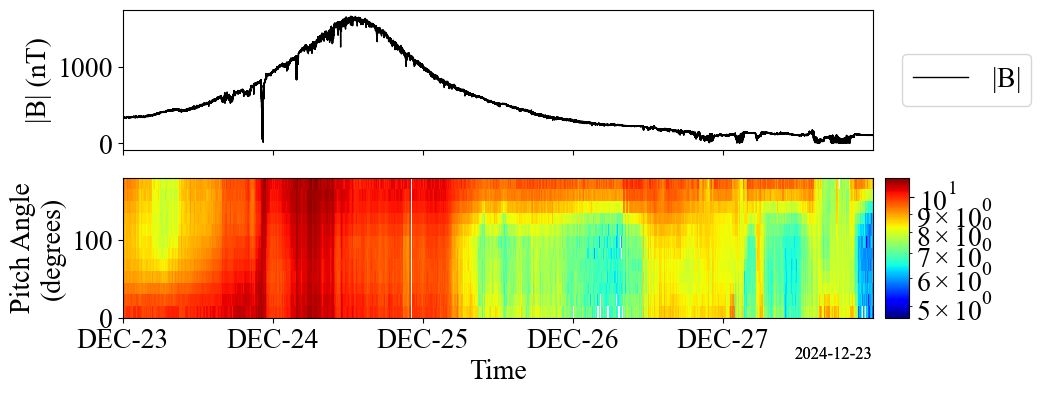

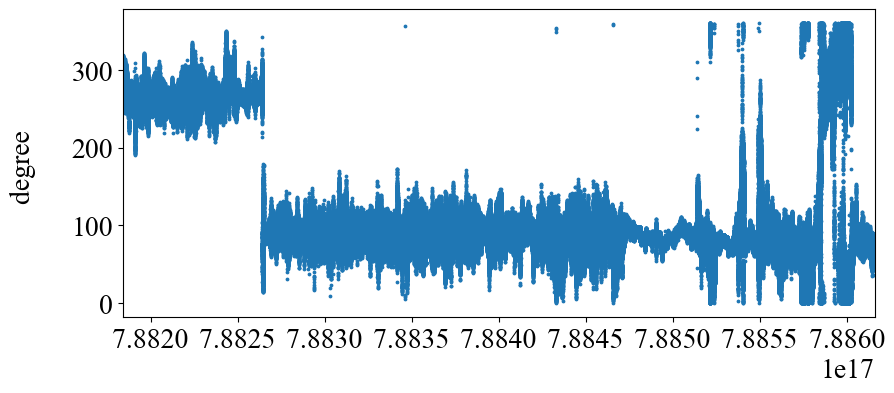

In [ ]:
print_manager.show_status = True

### Test hcs finder on PSP E22

# 1. Import tpad, tB, epad, phi_B
trange = ['2024-12-23/00:00:00.000','2024-12-29/00:00:00.000']
plotbot(trange,mag_rtn_4sa.bmag,1,epad.strahl,2)

tpad = np.array(epad.time)
tB = np.array(mag_rtn_4sa.time)
epad_test = 10**np.array(epad.strahl.data)
pangles = np.array(epad.pitch_angle_y_values)  # No .data needed - it's already a raw array
Br = np.array(mag_rtn_4sa.br.data)
Bn = np.array(mag_rtn_4sa.bn.data)

phi_B = np.degrees(np.arctan2(Br,Bn)) + 180
fig,ax=plt.subplots(1,1,figsize=(9.7,4))
ax.scatter(tB,phi_B,s=3)
ax.set_ylabel('degree \n')

# 2. Input tpad, tB, epad_test, phi_B into hcs_loc
hcs_sb,hcs_bounds = hcs_loc(tpad,tB,epad_test,phi_B,parapar_rats = [1/3,3],beam_bg_rats = [2/3,3/2],return_bounds=True,med_filter_len=49)
hcs_walls = strahl_walls(epad_test,pangles,region_inds=hcs_bounds)
for k in hcs_sb[0]:
    ax.axvline(tpad[k],ls='--',c='k')
for i in hcs_walls:
    ax.axvspan(tpad[hcs_bounds[i][0]],tpad[hcs_bounds[i][-1]],color='g',alpha=0.1)


In [ ]:
### Initialize Wind data
### Choose data

date = [2024,12,27,0,0,0]

days = 5
hours = 0
minutes = 0

date_e = [date[0] ,date[1], date[2] + days, date[3] + hours, date[4] + minutes, date[5]]

key_list = []
keylist_list = []

# lists of rich text strings for plot labels 
label_list = []
labellist_list = []

kB = 1.38e-23
mp = 1.67e-27


try:
    tB,Bmag,Bx,By,Bz = mfi_varsnip(date,hours = hours,days = days,dateloc='start')
    phi_B = np.degrees(np.arctan2(Bx,By)) + 180
    theta_B = np.degrees(np.arctan2(Bz,Bx)) + 180
    
    key_list_mfi = ['tB','Bmag','Bx','By','Bz','phi_B']
    key_list.extend(key_list_mfi)
    keylist_list.append(key_list_mfi)

    label_list_mfi = ['$t$','$B$','$B_x$','$B_y$$','$B_z$','$\phi_B$']
    label_list.extend(label_list_mfi)
    labellist_list.append(label_list_mfi)
    
except:
    print('Error: MFI')
    pass

try:
    t3pm,Vx,Vy,Vz,ni,na,p_temp,a_temp,flagpm = thrdp_varsnip(date,hours = hours,days = days,dateloc='start',isPAD=False)
    Vmag = np.sqrt(Vx**2+Vy**2+Vz**2)
    
    key_list_3dppm = ['t3pm','Vmag','Vx','Vy','Vz','ni','na','p_temp','a_temp','flagpm']
    key_list.extend(key_list_3dppm)
    keylist_list.append(key_list_3dppm)
    
    label_list_3dppm = ['$t$','$V$','$V_x$','$V_y$','$V_z$','$n_p$','$n_a$','$T_p$','$T_a$','quality flag']
    label_list.extend(label_list_3dppm)
    labellist_list.append(label_list_3dppm)

except:
    print('Error: 3dp key params')
    pass

try:
    t3pad,electronflux,pangle = thrdp_varsnip(date,hours = hours,days = days,dateloc='start',isPAD=True)
    electronflux = np.nan_to_num(electronflux,0)
    # ensure pangle uses 
    pangle_nan_fill = np.linspace(0,180,8)
    for i in range(pangle.shape[0]):
        if np.isnan(pangle[i]).any():
            for j in range(8):
                if np.isnan(pangle[i,j]):
                    pangle[i,j] = pangle_nan_fill[j]

    key_list_3dppad = ['t3pad','electronflux','pangle']
    key_list.extend(key_list_3dppad)
    keylist_list.append(key_list_3dppad)

    label_list_3dppad = ['$t$','flux','pitch angle $(^\\degree)$']
    label_list.extend(label_list_3dppad)
    labellist_list.append(label_list_3dppad)

except:
    print('Error: 3dp PADs')
    pass

try:
    tswepa,Wp,Wa,Vp,Va,tswee,Te,Wparp,Wperpp,Wpara,Wperpa,flagswe = swe_varsnip(date,hours = hours,days = days,dateloc='start',isPAD=False)
    
    Tperpp = 10**6 * Wperpp**2 * mp/ (2 * kB) / 11604
    Tparp = 10**6 * Wparp**2 * mp/ (2 * kB) / 11604
    Tparp[Tparp > 1000] = 0
    Tperpp[Tperpp > 1000] = 0
    
    key_list_swepa = ['tswepa','Tperpp','Tparp','Wa','Vp','Va']
    key_list_swee = ['tswee','Te','flagswe']
    key_list.extend(key_list_swepa)
    keylist_list.append(key_list_swepa)
    key_list.extend(key_list_swee)
    keylist_list.append(key_list_swee)

    label_list_swepa = ['$t$','$T_{p,\\perp}$','$T_{p,\\parallel}$','$W_a$','$V_p$','$V_a$']
    label_list_swee = ['$t$','$T_e$','quality flag']
    label_list.extend(label_list_swepa)
    labellist_list.append(label_list_swepa)
    label_list.extend(label_list_swee)
    labellist_list.append(label_list_swee)

except:
    print('Error: SWE temps')
    pass

try:
    tswepad,e00,e01,e02,e03,e04,e05,e06,e07,e08,e09,e10,e11,e12 = swe_varsnip(date,hours = hours,days = days,dateloc='start',isPAD=True)
    key_list_swepad = ['tswepad','e00','e01','e02','e03','e04','e05','e06','e07','e08','e09','e10','e11','e12']
    key_list.extend(key_list_swepad)
    keylist_list.append(key_list_swepad)
    
    label_list_swepad = ['$t$','e00','e01','e02','e03','e04','e05','e06','e07','e08','e09','e10','e11','e12']
    label_list.extend(label_list_swepad)
    labellist_list.append(label_list_swepad)
except:
    print('Error: SWE PADs')
    pass

epoch_choice = dict()
for keylist in keylist_list:
    for key in keylist[1:]:
        epoch_choice[key] = keylist[0]


# Get variable name from local variables based on dict key 
var_dict = dict()
for i in (key_list):
    var_dict[i] = locals()[i]

label_dict = dict()
for i in range(len(key_list)):
    label_dict[key_list[i]] = label_list[i]



25-Sep-25 15:51:32: <>:32: SyntaxWarning: invalid escape sequence '\p'

25-Sep-25 15:51:32: <>:32: SyntaxWarning: invalid escape sequence '\p'

25-Sep-25 15:51:32: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_935/3799319175.py:32: SyntaxWarning: invalid escape sequence '\p'
  label_list_mfi = ['$t$','$B$','$B_x$','$B_y$$','$B_z$','$\phi_B$']



5120
Invalid path/missing file:/Users/sfordin/Wind/SWE/2024/wi_h5_swe_20241229
3655
32654


In [ ]:
### Initialize SolO data
date = [2024,12,24,0,0,0]

days = 7
hours = 0
minutes = 0

remake_label_lists = True

if remake_label_lists:

    ## dict of epoch references 
    epoch_choice = dict()

    ## list of variable names to reference as strings
    key_list = []
    keylist_list = []

    ## lists of rich text strings for plot labels 
    label_list = []
    labellist_list = []


date_e = [date[0] ,date[1], date[2] + days, date[3] + hours, date[4] + minutes, date[5]]

key_list_solo = []
keylist_list_solo = []

# lists of rich text strings for plot labels 
label_list_solo = []
labellist_list_solo = []

kB = 1.38e-23
mp = 1.67e-27

try:
    tB_solo,Bx_solo,By_solo,Bz_solo,flag_mag = solo_mag_varsnip(date,hours = hours,days = days,dateloc='start')
    phi_B_solo = np.degrees(np.arctan2(Bx_solo,By_solo)) + 180
    theta_B_solo = np.degrees(np.arctan2(Bz_solo,Bx_solo)) + 180
    
    key_list_mag = ['tB_solo','Bx_solo','By_solo','Bz_solo','phi_B_solo']
    key_list.extend(key_list_mag)
    keylist_list.append(key_list_mag)

    label_list_mag = ['$t$','$B_x$','$B_y$','$B_z$','$\phi_B$']
    label_list.extend(label_list_mag)
    labellist_list.append(label_list_mag)
    
except:
    print('Error: SolO MAG')
    pass

try:
    tp_solo,Vx_solo,Vy_solo,Vz_solo,Np_solo,Tx_solo,Ty_solo,Tz_solo,flag_swa = solo_swa_varsnip(date,hours = hours,days = days,dateloc='start')
    key_list_swa = ['tp_solo','Vx_solo','Vy_solo','Vz_solo','Np_solo','Tx_solo','Ty_solo','Tz_solo','flag_swa']
    key_list.extend(key_list_swa)
    keylist_list.append(key_list_swa)

    label_list_swa = ['$t$','$V_x$','$V_y$','$V_z$','$n_p$','$T_x$','$T_y$','$T_z$','flag']
    label_list.extend(label_list_swa)
    labellist_list.append(label_list_swa)
    
except:
    print('Error: SolO SWA')
    pass

# lists of rich text strings for plot labels 

for keylist in keylist_list:
    for key in keylist[1:]:
        epoch_choice[key] = keylist[0]

## Select time range
for keylist in keylist_list:
    for key in keylist[1:]:
        epoch_choice[key] = keylist[0]

# Select variable name 
var_dict = dict()
for i in (key_list):
    var_dict[i] = locals()[i]

label_dict = dict()
for i in range(len(key_list)):
    label_dict[key_list[i]] = label_list[i]


24-Sep-25 00:20:46: <>:45: SyntaxWarning: invalid escape sequence '\p'

24-Sep-25 00:20:46: <>:45: SyntaxWarning: invalid escape sequence '\p'

24-Sep-25 00:20:46: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/1729297661.py:45: SyntaxWarning: invalid escape sequence '\p'
  label_list_mag = ['$t$','$B_x$','$B_y$','$B_z$','$\phi_B$']



In [ ]:
### Plot SolO data

## list of (mixed-type) variable names given as single strings or as lists of strings

plot_list = [['Bx_solo','By_solo','Bz_solo'],
             'phi_B_solo',
             ['Vx_solo','Vy_solo','Vz_solo'],
             'Np_solo',
             ['Tx_solo','Ty_solo','Tz_solo']]
color_list = ['blue','orange','green']
n = len(plot_list)
ticklocs,ticklabels = tasteful_ticks(tp_solo)

fig,ax=plt.subplots(n,1,figsize=(8,3 * n),layout='compressed')

for i in range(0,n):

    var_name = plot_list[i]
    ## check type of var_name: 
    ##  -if it is a single variable name, plot that variable
    ##  -if it is a list of variable name strings, obtain info for each variable and plot within same panel

    ##  -str case
    if type(var_name) is str:
        t_name = epoch_choice[var_name]
        var_ass = var_dict[var_name]
        t_ass = var_dict[t_name]
        plot_label = label_dict[var_name]
        lt = np.shape(t_ass)[0]
        ax[i].plot(t_ass,var_ass,label='{}'.format(plot_label))
        ax[i].set_ylabel(r'{}'.format(plot_label))
        if var_name == 'phi_B_solo':
            ax[i].set_ylim([0,360])
            ax[i].set_yticks([0,90,180,270,360])

    ##  -list case
    elif type(var_name) is list:
        plot_ylabel = []
        for k in range(len(var_name)):
            
            t_name = epoch_choice[var_name[k]]
            
            var_ass = var_dict[var_name[k]]
            t_ass = var_dict[t_name]
            
            plot_label = label_dict[var_name[k]]
            plot_ylabel.append(plot_label)

            lt = np.shape(t_ass)[0]
            ax[i].plot(t_ass,var_ass,color=color_list[k],label='{}'.format(plot_label))
            if var_name[k] == 'phi_B_solo':
                ax[i].set_ylim([0,360])
                ax[i].set_yticks([0,90,180,270,360])
    
        ax[i].set_ylabel(r'{}'.format(plot_ylabel))
        ax[i].legend(frameon=False,bbox_to_anchor=(1,1))

    ax[i].set_xticks(ticklocs)
    ax[i].set_xticklabels(ticklabels)
    ax[i].locator_params(axis='x', nbins=6)
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(n = 5))


NameError: name 'tp_solo' is not defined

25-Aug-25 13:51:44: <ipython-input-8-293016b4edb8>:91: RuntimeWarning: invalid value encountered in true_divide
  unidir_ratio = par_counts/antipar_counts

25-Aug-25 13:51:44: <ipython-input-8-293016b4edb8>:103: RuntimeWarning: invalid value encountered in true_divide
  par_atrop_ratio = par_counts/bg_counts

25-Aug-25 13:51:44: <ipython-input-8-293016b4edb8>:104: RuntimeWarning: invalid value encountered in true_divide
  antipar_atrop_ratio = antipar_counts/bg_counts

25-Aug-25 13:51:47: <ipython-input-32-443433c115ea>:116: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('hcs params 082525, days={}.pdf'.format(days),format='pdf',bbox_inches='tight')

25-Aug-25 13:52:03: <ipython-input-32-443433c115ea>:116: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('hcs params 082525, days={}.pdf'.format(days),format='pdf',bbox_inches='tight')

25-Aug-25 13:52:10: /Applications/anaconda3/lib/pyth

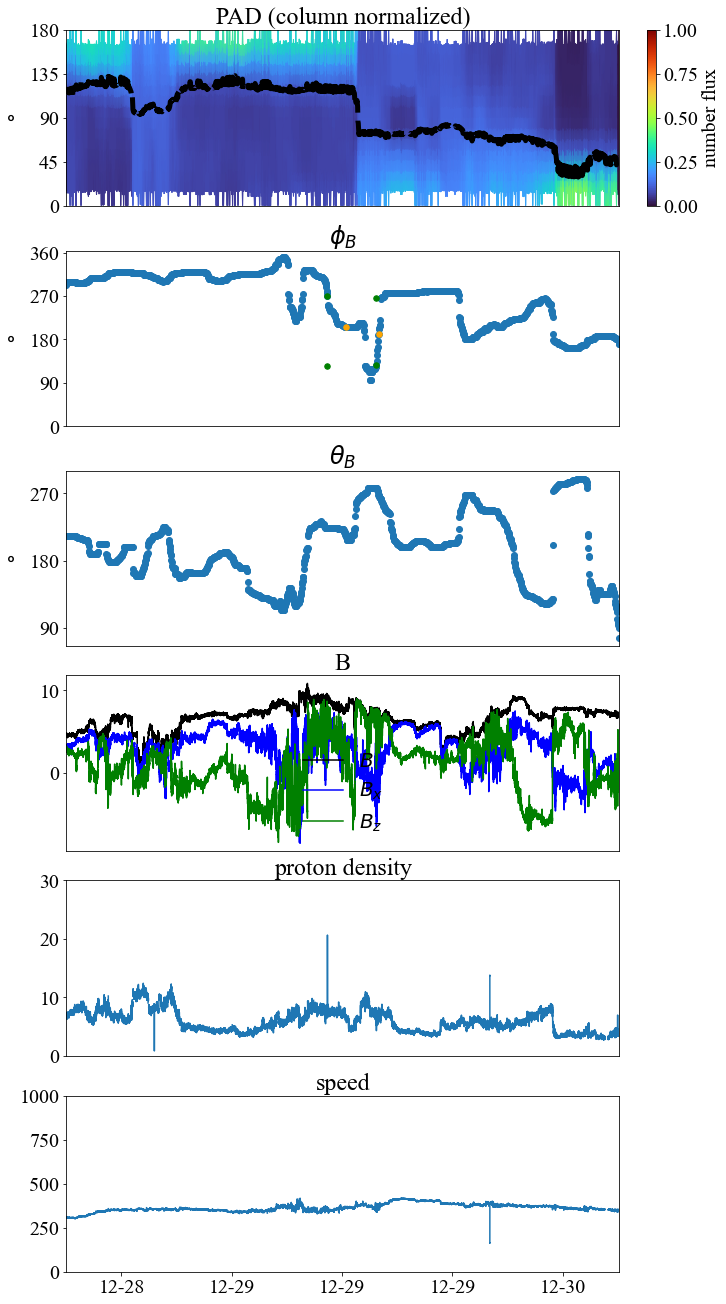

In [ ]:
### Plot solar wind parameters in time range

plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.family': 'Times New Roman'})


med_filter_len = 49

phi_B_ds = resample(phi_B,new_times=t3pad,times=tB)[1] # resample phi_B at same cadence as PADs
phi_B_median = scipy.signal.medfilt(phi_B_ds,kernel_size = med_filter_len)

theta_B_ds = resample(theta_B,new_times=t3pad,times=tB)[1] # resample phi_B at same cadence as PADs
theta_B_median = scipy.signal.medfilt(theta_B_ds,kernel_size = med_filter_len)

hcs_sb,hcs_regions = hcs_loc(t3pad,tB,electronflux,phi_B,med_filter_len=med_filter_len,buffer_range=0,return_bounds=True)
hcs_walls = strahl_walls(electronflux,pangle,region_inds=hcs_regions)

rot_bounds,rot_mids = autochord(phi_B_median)

# for j in range(len(rot_times)):
#     plt.scatter(rot_bounds[j][0],phi_B_median[rot_bounds[j][0]],c='green',s=100)
#     plt.scatter(rot_bounds[j][1],phi_B_median[rot_bounds[j][1]],c='green',s=100)
fig,ax=plt.subplots(6,1,figsize=(10,18),layout='compressed')
t3pad_mesh = np.expand_dims(t3pad,axis=0)
t3pad_mesh = np.repeat(t3pad_mesh,8,axis=0).T
cmap_min = np.max([np.ma.min(electronflux[:,:,4][electronflux[:,:,4] > 0]),1e3])
cmap_max = np.min([np.ma.max(electronflux[:,:,4][electronflux[:,:,4] > 0]),4e5])

# pcmesh = ax[0].pcolormesh(t3pad_mesh,pangle,(electronflux[:,:,4]),cmap='turbo',norm=colors.LogNorm(vmin=cmap_min,vmax=cmap_max),shading='gouraud')
epad = electronflux[:,:,4]
epad_med = scipy.signal.medfilt2d(epad,kernel_size=(med_filter_len,1))
    
epad_norm = np.zeros(epad.shape)
epad_med_norm = np.zeros(epad.shape)
for k in range(epad.shape[0]):
    epad_ma = np.ma.array(epad[k,:],mask=epad[k,:] == 0)
    col_sum = np.ma.sum(epad[k,:])
    epad_norm[k,:] = epad_ma/col_sum if col_sum > 0 else 0

    epad_ma = np.ma.array(epad_med[k,:],mask=epad_med[k,:] == 0)
    col_sum = np.ma.sum(epad_med[k,:])
    epad_med_norm[k,:] = epad_ma/col_sum if col_sum > 0 else 0
    
pcmesh = ax[0].pcolormesh(t3pad_mesh,pangle,epad_med_norm,cmap='turbo',vmin=0,vmax=1,shading='gouraud')

# pcmesh = ax[0].pcolormesh(t3pad_mesh,pangle,(electronflux[:,:,4]),cmap='turbo',vmin=cmap_min,vmax=cmap_max,shading='gouraud')
cbar=fig.colorbar(pcmesh, ax=ax[0])
cbar.set_label('number flux', rotation=90)

centroids_epad = np.ma.average(pangle,weights=epad_med,axis=1)
ax[0].plot(t3pad,centroids_epad,color='k',ls='--',lw=5)

# for i in range(len(strahl_regions)):
#     colors_list = ['purple','orange','magenta']
#     ax[0].fill_betweenx([0,200],t3pad[strahl_contig_inds[i][0]],t3pad[strahl_contig_inds[i][1]],color=colors_list[strahl_regions[i][0]],alpha=0.3)

p_range = [0,t3pad.size]
ax[1].scatter(t3pad[p_range[0]:p_range[1]],phi_B_median[p_range[0]:p_range[1]])
for i in rot_mids:
    ax[1].scatter(t3pad[i],phi_B_median[i],c='orange',s=30)
for (i,j) in rot_bounds:
    ax[1].scatter(t3pad[i],phi_B_median[i],c='green',s=30)
    ax[1].scatter(t3pad[i],phi_B_median[j],c='green',s=30)
# for i in range(len(hcs_regions)):
#     ax[0].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='k',alpha=0.1)
#     ax[1].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='k',alpha=0.1)
#     ax[2].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='k',alpha=0.1)
#     ax[3].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='k',alpha=0.1)
#     ax[4].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='k',alpha=0.1)
#     ax[5].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='k',alpha=0.1)

# for i in hcs_walls:
#     ax[0].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='g',alpha=0.1)
#     ax[1].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='g',alpha=0.1)
#     ax[2].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='g',alpha=0.1)
#     ax[3].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='g',alpha=0.1)
#     ax[4].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='g',alpha=0.1)
#     ax[5].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='g',alpha=0.1)

ax[0].set_title('PAD (column normalized)')
ax[0].set_ylabel(r'$\degree$')
ax[0].set_yticks([0,45,90,135,180])
ax[1].set_title(r'$\phi_B$')
ax[1].set_ylabel(r'$\degree$')
ax[1].set_yticks([0,90,180,270,360])
ax[2].set_title(r'$\theta_B$')
ax[2].set_ylabel(r'$\degree$')
ax[2].set_yticks([0,90,180,270,360])

tick_locs,tick_labels = tasteful_ticks(t3pad,num_ticks=5)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])
ax[4].set_xticks([])
ax[5].set_xticks(tick_locs)

ax[5].set_xticklabels(tick_labels)

ax[2].scatter(t3pad,theta_B_median)

ax[3].plot(tB,Bmag,c='k',label=r'$B$')
ax[3].plot(tB,Bx,c='blue',label=r'$B_x$')
ax[3].plot(tB,Bz,c='green',label=r'$B_z$')
ax[3].set_title('B')
ax[3].legend(frameon=False)

ax[4].plot(t3pm,ni)
ax[4].set_ylim([0,30])
ax[4].set_title('proton density')

ax[5].plot(t3pm,Vmag)
ax[5].set_title('speed')
ax[5].set_ylim([0,1000])

plt.savefig('hcs params 082525, days={}.pdf'.format(days),format='pdf',bbox_inches='tight')


In [ ]:
### Plot wave locations

# ## 0. Import
# try:
#     d_temp = pd.read_csv('/Volumes/T9/mva params/mva_params_{}_{}_081425.csv'.format(2024,12))
    
#     preds_list = d_temp.values[:,-1]  
#     date_starts = d_temp.values[:,0]
      
# except:
#     print('mva param error: {} {}'.format(2024,12))

## 1. Start and end dates for each interval in terms of t3pad
# start_epochs = [cdf.cdfepoch.compute_epoch([int(date_starts[i][0:4]),int(date_starts[i][5:7]),int(date_starts[i][8:10]),
#                                             int(date_starts[i][11:13]),int(date_starts[i][14:16]),int(date_starts[i][17:19]),
#                                             int(date_starts[i][20:])]) for i in range(len(date_starts))]

# start_tB = np.argmax(tB > start_epochs[0])
end_tB = np.argmax(tB > start_epochs[-1] + 66)


## 2. Plot locations of wave interval midpoints on t3pad

# preds_arr = np.array(preds_list)
# good_inds = np.where(preds_arr > 0.95)

tick_locs,tick_labels = tasteful_ticks(tB,num_ticks=5)

t_vals = np.zeros(tB.size)

for k in good_inds:
    t_vals[start_epochs[k]:start_epochs[k] + 66] = 1

fig,ax=plt.subplots(1,1)

ax.plot(tB,t_vals)

ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)

TypeError: only integer scalar arrays can be converted to a scalar index

Text(0.5, 1.0, 'median filtered col normed PAD')

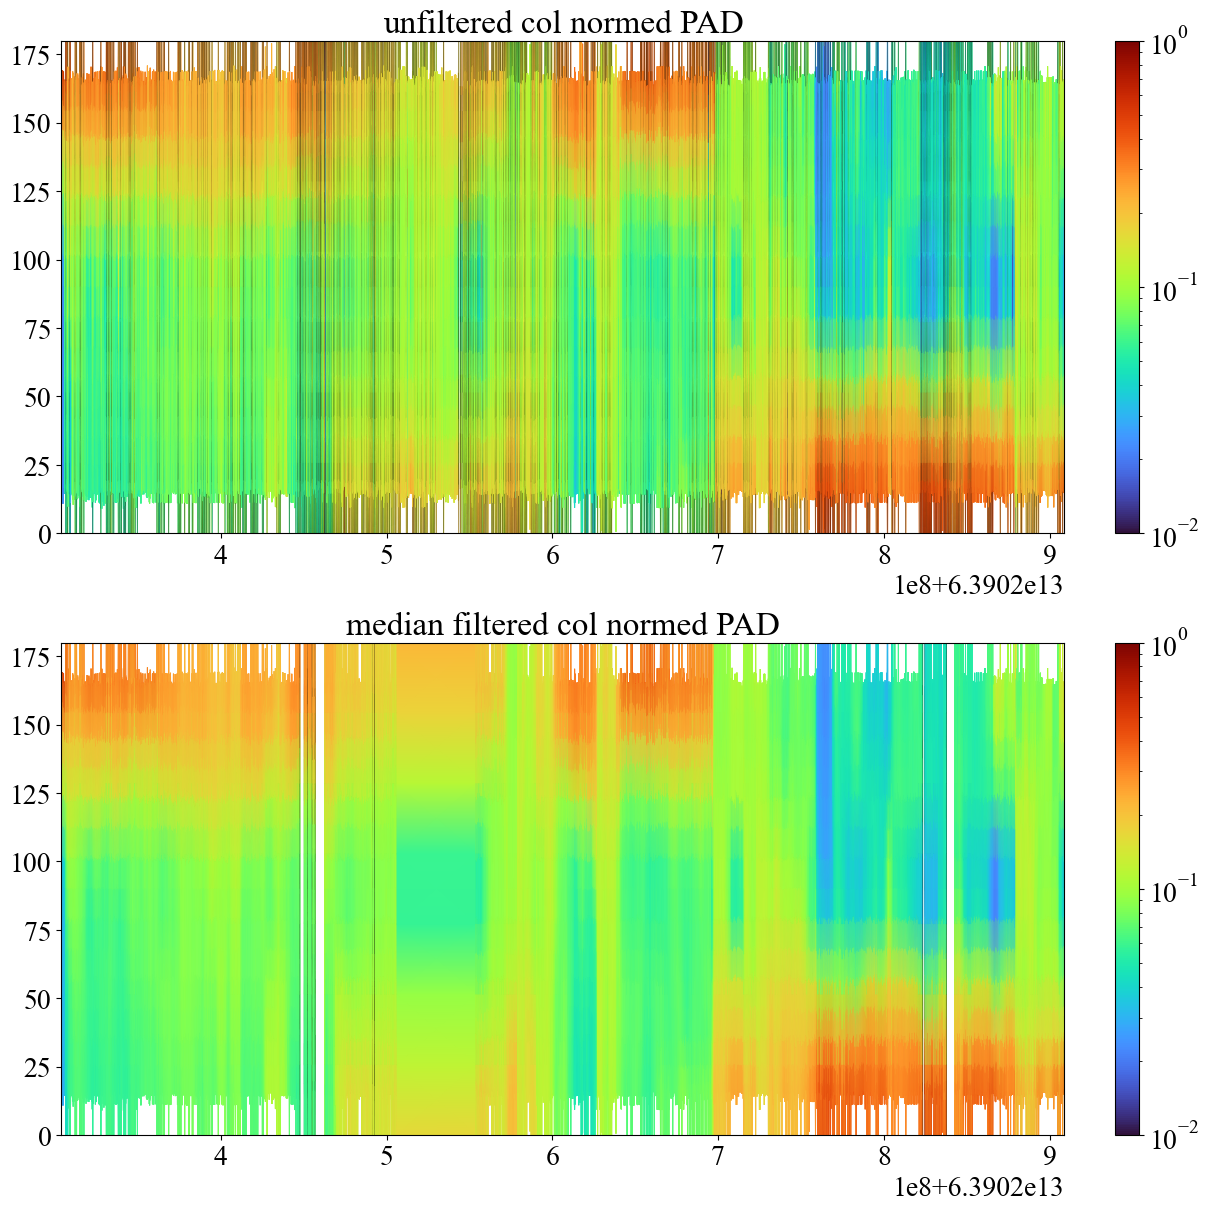

In [ ]:
### column normalization of epads
epad = electronflux[:,:,4]
epad_med = scipy.signal.medfilt2d(epad,kernel_size=(med_filter_len,1))
    
epad_norm = np.zeros(epad.shape)
epad_med_norm = np.zeros(epad.shape)
for k in range(epad.shape[0]):
    epad_ma = np.ma.array(epad[k,:],mask=epad[k,:] == 0)
    col_sum = np.ma.sum(epad[k,:])
    epad_norm[k,:] = epad_ma/col_sum if col_sum > 0 else 0

    epad_ma = np.ma.array(epad_med[k,:],mask=epad_med[k,:] == 0)
    col_sum = np.ma.sum(epad_med[k,:])
    epad_med_norm[k,:] = epad_ma/col_sum if col_sum > 0 else 0


fig,ax=plt.subplots(2,1,figsize=(12,12),layout='compressed')

t3pad_mesh = np.expand_dims(t3pad,axis=0)
t3pad_mesh = np.repeat(t3pad_mesh,8,axis=0).T

pcmesh = ax[0].pcolormesh(t3pad_mesh,pangle,epad_norm,cmap='turbo',norm=colors.LogNorm(vmin=1e-2,vmax=1),shading='gouraud')
cbar=fig.colorbar(pcmesh, ax=ax[0])
ax[0].set_title('unfiltered col normed PAD')

pcmesh = ax[1].pcolormesh(t3pad_mesh,pangle,epad_med_norm,cmap='turbo',norm=colors.LogNorm(vmin=1e-2,vmax=1),shading='gouraud')
cbar=fig.colorbar(pcmesh, ax=ax[1])
ax[1].set_title('median filtered col normed PAD')


In [ ]:
### Compute metric: distance from HCS

## For each interval midpoint, compute shortest time delta to hcs_flag == 1

## 1. Compute hcs_loc at each month
for y in range(2024,2026):
    for m in range(1,13):
        
        date = [y,m,15,0,0,0]

        days = 25
        hours = 0
        minutes = 0
        date_e = [date[0] ,date[1], date[2] + days, date[3] + hours, date[4] + minutes, date[5]]

        key_list = []
        keylist_list = []

        # lists of rich text strings for plot labels 
        label_list = []
        labellist_list = []

        kB = 1.38e-23
        mp = 1.67e-27

        try:
            tB,Bmagt,Bxt,Byt,Bzt = mfi_varsnip(date,hours = hours,days = days,dateloc='mid',)
            phi_B = np.degrees(np.arctan2(Bxt,Byt)) + 180
        except:
            print('Error: MFI')
            pass    
        try:
            t3pad,electronflux,pangle = thrdp_varsnip(date,hours = hours,days = days,dateloc='mid',isPAD=True)
            electronflux = np.nan_to_num(electronflux,0)
            # ensure pangle uses 
            pangle_nan_fill = np.linspace(0,180,8)
            for i in range(pangle.shape[0]):
                if np.isnan(pangle[i]).any():
                    for j in range(8):
                        if np.isnan(pangle[i,j]):
                            pangle[i,j] = pangle_nan_fill[j]

        except:
            print('Error: 3dp PADs')
            continue

        # for each month, access start and end info
        # 
        try:
            d_temp = pd.read_csv('/Volumes/Seagate/Paper 2/data by month/sw params by month/sw_params_{}_{}_123024.csv'.format(y,m))
            date_starts = d_temp.values[:,0]
            date_ends = d_temp.values[:,1]
        except:
            print('sw param error: {} {}'.format(y,m))
            continue
        try:
            d_temp = pd.read_csv('/Volumes/Seagate/Paper 2/data by month/mva params by month/mva_params_{}_{}_123024.csv'.format(y,m))
            preds_list = d_temp.values[:,-1]        
        except:
            print('mva param error: {} {}'.format(y,m))
            continue

    # 2. for each month, compute distance between interval midpoints and nearest hcs region

        start_epochs = [cdf.cdfepoch.compute_epoch([int(date_starts[i][0:4]),int(date_starts[i][5:7]),int(date_starts[i][8:10]),
                                                   int(date_starts[i][11:13]),int(date_starts[i][14:16]),int(date_starts[i][17:19]),
                                                   int(date_starts[i][20:])]) for i in range(len(date_starts))]
        end_epochs = [cdf.cdfepoch.compute_epoch([int(date_ends[i][0:4]),int(date_ends[i][5:7]),int(date_ends[i][8:10]),
                                                   int(date_ends[i][11:13]),int(date_ends[i][14:16]),int(date_ends[i][17:19]),
                                                   int(date_ends[i][20:])]) for i in range(len(date_ends))]
        t_mids = [0.5*(start_epochs[i] + end_epochs[i]) for i in range(len(start_epochs))]

        start_tpad = np.argmax(t3pad > t_mids[0])
        end_tpad = np.argmax(t3pad > t_mids[-1]) - 1

        start_tB = np.argmax(tB > t_mids[0])
        end_tB = np.argmax(tB > t_mids[-1]) - 1

        # for each month, compute hcs_bounds (locations of )

        hcs_sb, hcs_bounds = hcs_loc(t3pad,tB,electronflux,phi_B,med_filter_len=49,return_bounds=True)
        hcs_walls = strahl_walls(electronflux,pangle,region_inds=hcs_bounds)
        hcs_bounds = [[hcs_bounds[k][0],hcs_bounds[k][1]] for k in hcs_walls]
        
        # distance metric
        dist_from_hcs = -1 * np.ones(len(t_mids))
        last_mid = t_mids[-1]
        
        ## split into two pieces
        # A. If we are in hcs, dist_from_hcs = 0
        k = 0 # index of t_mids
        for (i_s,i_e) in hcs_bounds:

            # ensure tpad times are within desired range
            if i_e > start_tpad and i_s < end_tpad:
                
                hcs_subint = t3pad[i_s:i_e]

                while t_mids[k] < hcs_subint[-1]:

                    if t_mids[k] > hcs_subint[0]:
                        dist_from_hcs[k] = 0

                    if k < len(t_mids) - 1:
                        k += 1
                    else:
                        break

        # B. If we are out of hcs, dist_from_hcs = min(dist from hcs bounds)
        leftover_inds = np.where(dist_from_hcs < 0)[0]
        for j in leftover_inds:
            flattened_hcs_t = t3pad[np.concatenate(hcs_bounds)]
            dist_from_hcs[j] = np.min(np.absolute(t_mids[j] - flattened_hcs_t))/1000/3600

        ### 3. Save to cdf
        with open('/Users/sfordin/Documents/Paper 2/sw params/hcs_dist_{}_{}_072525.csv'.format(y,m),'a') as fd:
            fd.write('Start_date,End_date,\
            hcs_dist_h' + "\n")
            for i in range(len(t_mids)):

                event_string = ','.join(map(str,[date_starts[i],date_ends[i],
                                                 dist_from_hcs[i].astype('float32')]))
                fd.write(event_string + "\n")



43219
sw param error: 2024 1
Invalid path/missing file:/Users/sfordin/Wind/MFI/2024/wi_h2_mfi_20240222_v05.cdf


6.94% of all intervals are in hcs


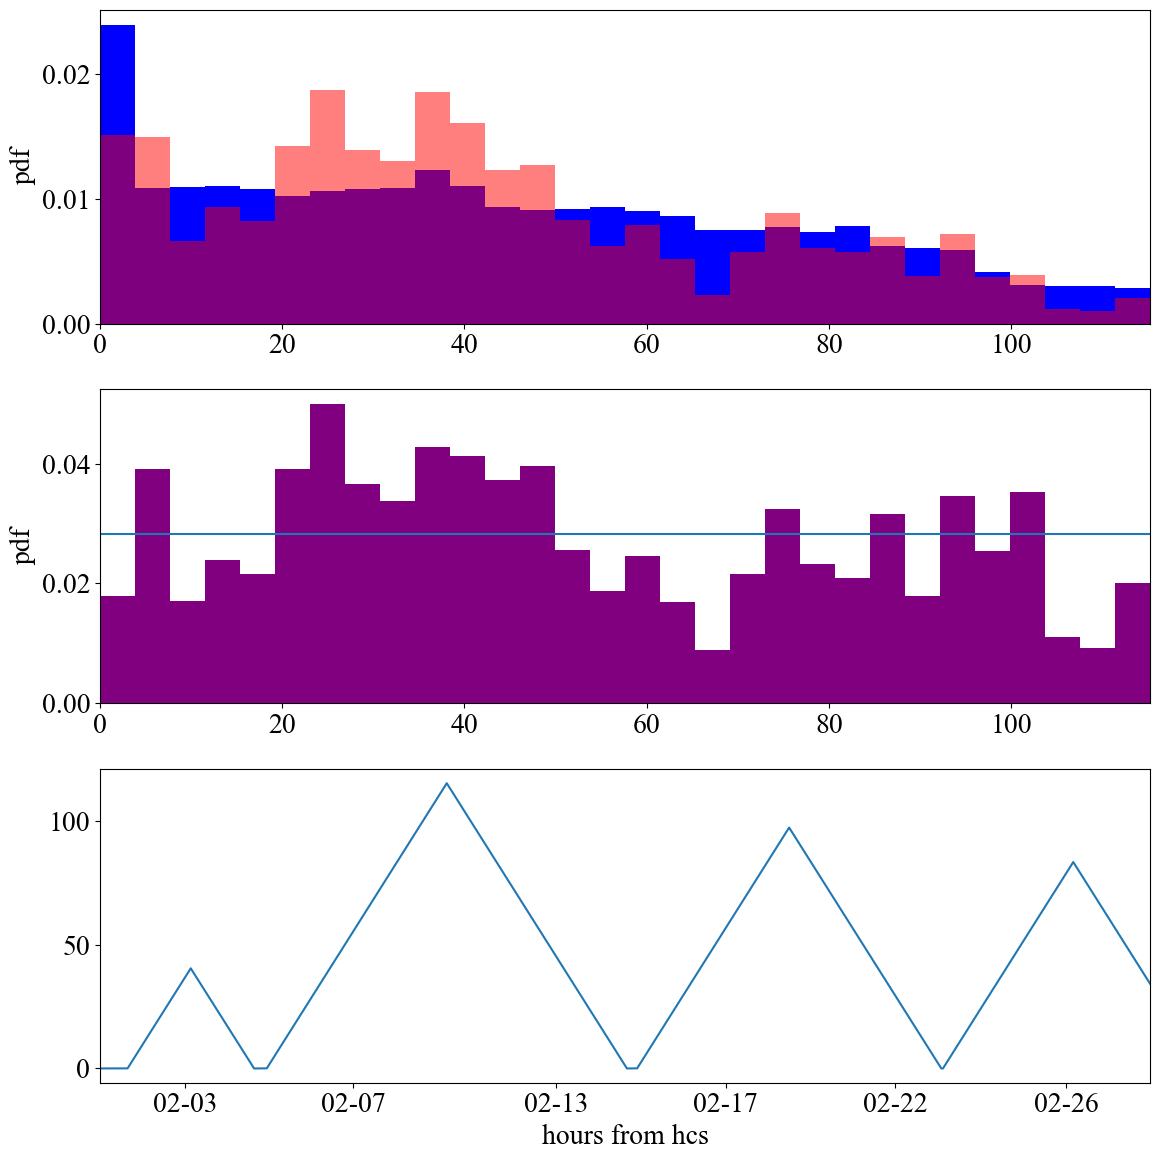

In [ ]:
### Plot distance from hcs
good_inds = np.where(preds_list > 0.95)[0]

fig,ax=plt.subplots(3,1,figsize=(12,12))
ax[0].hist(dist_from_hcs,bins=30,density=True,color='blue')
ax[0].hist(dist_from_hcs[good_inds],bins=30,density=True,color='red',alpha=0.5)
ax[0].set_ylabel('pdf')
ax[0].set_title('')

hcs_len = 0
for (i,j) in hcs_bounds:
    hcs_len += j - i
print('{:.2%}'.format(hcs_len/t3pad.size) + ' of all intervals are in hcs')

rat_hist = np.histogram(dist_from_hcs[good_inds],bins=30)[0]/np.histogram(dist_from_hcs,bins=30)[0]
bins = np.histogram(dist_from_hcs,bins=30)[1]
bin_widths = np.diff(bins)
ax[1].bar(bins[:-1] + bin_widths/2,rat_hist,width=bin_widths,color='purple')
ax[1].axhline(good_inds.size/len(preds_list))
ax[1].set_ylabel('ratio')


ax[2].plot(t_mids,dist_from_hcs)
tick_params = tasteful_ticks(t_mids)
ax[2].set_xticks(tick_params[0])
ax[2].set_xticklabels(tick_params[1])

ax[2].set_xlabel('hours from hcs')

plt.tight_layout()


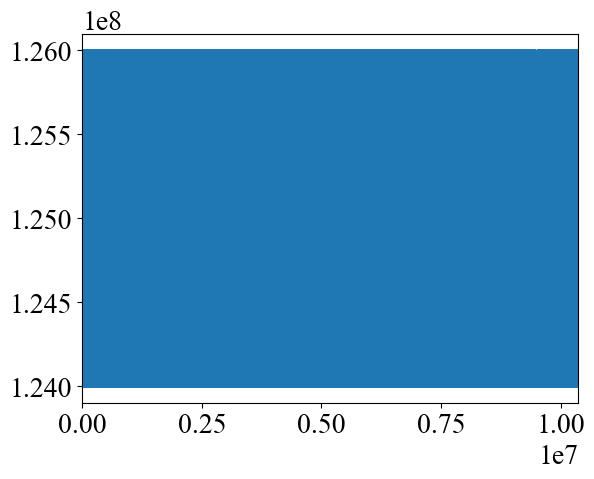

In [ ]:
plt.plot(np.diff(tB_solo))

In [ ]:
### Compute wavelet
### Load data as a dataframe with columns Bx,By,Bz and indexed by time

start_t = cdf.cdfepoch.compute_epoch(date)
end_t = cdf.cdfepoch.compute_epoch(date_e)
t_dt = cdf.cdfepoch.breakdown(tB_solo)

t_dt = [dt.datetime(year=t_dt[i][0],month=t_dt[i][1],day = t_dt[i][2],hour=t_dt[i][3],minute=t_dt[i][4],second=t_dt[i][5],microsecond= t_dt[i][6]*1000) for i in range(len(t_dt))]
    
# delta_t = 1/11 # Wind cadence
delta_t = 1/16 # SolO cadence

f_range = [5e-2,3]
f_n = 32

start = np.argmax(tB_solo > start_t)
end = np.argmax(tB_solo < end_t)



df = pd.DataFrame(data=np.vstack([Bx_solo,By_solo,Bz_solo]).T,columns=['Bx','By','Bz'])
print(df)
if df['Bx'].isna().sum()/len(df.Bx)<=0.1 and df['By'].isna().sum()/len(df.By)<=0.1 and df['Bz'].isna().sum()/len(df.Bz)<=0.1 :

    df=df.interpolate()
    df=df.dropna()


    time_axis = np.linspace(0, df.Bx.shape[0], df.Bx.shape[0])
    mu_0 = 4*np.pi*1e-7#N/A^2=kg.m/(s^2.A^2)
    m_proton=1.673*1e-27#kg
    
    rho = 7*m_proton*1e6*5/6 # kg m^{-3} see Good et al. 2022 MNRAS for more details
    
    # playing around with random values
    vx_n = np.repeat(400*1e3,df.Bx.shape[0]) # m/s
    vy_n = np.repeat(30*1e3,df.Bx.shape[0]) # m/s
    vz_n = np.repeat(-40*1e3,df.Bx.shape[0]) # m/s
    
    # tem = tem*1e3 # m s^{-1}
    
    bx_n = (1e-9*df.Bx)/np.sqrt(mu_0*rho) # m/s
    by_n = (1e-9*df.By)/np.sqrt(mu_0*rho) # m/s
    bz_n = (1e-9*df.Bz)/np.sqrt(mu_0*rho) # m/s
    
    radi=180/(4*np.arctan(1))
    ph=radi*np.arctan2(df.By,df.Bx)
    gg=np.where((ph < 0)); 
    for i in gg:
        ph[i]=radi*np.arctan2(df.By[i],df.Bx[i])+360.
    
    z_plusx = vx_n+bx_n
    z_plusy = vy_n+by_n
    z_plusz = vz_n+bz_n

    z_minusx=vx_n-bx_n
    z_minusy=vy_n-by_n
    z_minusz=vz_n-bz_n
    #select the inertial range (1e-4-1e-2 hz), dt=1min=60sec
    # print('uo')
    my_wavelet2go = Wavelet2Go(f_n=f_n, f_min=f_range[0], f_max=f_range[1], dt=delta_t) # Telloni et al 2020
    yticks,ytickfreqs = my_wavelet2go.get_y_ticks(reduction_to=5)
    xticks,xtickfreqs = my_wavelet2go.get_x_ticks(reduction_to=int(60*(60/delta_t)/2),data=df.Bx)
    cwtbfx, freqs = my_wavelet2go.perform_transform(df.Bx-np.mean(df.Bx))
    cwtbfy, freqs = my_wavelet2go.perform_transform(df.By-np.mean(df.By))
    cwtbfz, freqs = my_wavelet2go.perform_transform(df.Bz-np.mean(df.Bz))   
    eb_fluc=(abs(cwtbfx)**2+abs(cwtbfy)**2+abs(cwtbfz)**2)



    cwtbx, freqs = my_wavelet2go.perform_transform(df.Bx)
    cwtby, freqs = my_wavelet2go.perform_transform(df.By)
    cwtbz, freqs = my_wavelet2go.perform_transform(df.Bz)

    
    a=2*(np.conj(cwtby)*cwtbz).imag
    b=(abs(cwtby)**2+abs(cwtbz)**2)
    a=my_wavelet2go.mask_invalid_data(a, fill_value=0)
    b=my_wavelet2go.mask_invalid_data(b, fill_value=0)
    sigm=a/b #######                                         magnetic helicity

    
else:
    print("not possible")

#############################################################



KeyboardInterrupt: 

In [ ]:
### Testing the wavelet transform

## 1. Initialize two different time series
t1 = [50000,100000]
t2 = [60000,110000]

# delta_t = 1/11 # Wind cadence
delta_t = 1/16 # SolO cadence

f_range = [5e-2,8]
f_n = 128


df1 = pd.DataFrame(data=np.vstack([Bx_solo[t1[0]:t1[1]],By_solo[t1[0]:t1[1]],Bz_solo[t1[0]:t1[1]]]).T,columns=['Bx','By','Bz'])
df2 = pd.DataFrame(data=np.vstack([Bx_solo[t2[0]:t2[1]],By_solo[t2[0]:t2[1]],Bz_solo[t2[0]:t2[1]]]).T,columns=['Bx','By','Bz'])

eb_fluc = []
sigm = []

for df in [df1,df2]:
    if df['Bx'].isna().sum()/len(df.Bx)<=0.1 and df['By'].isna().sum()/len(df.By)<=0.1 and df['Bz'].isna().sum()/len(df.Bz)<=0.1 :

        df=df.interpolate()
        df=df.dropna()

        time_axis = np.linspace(0, df.Bx.shape[0], df.Bx.shape[0])
        mu_0 = 4*np.pi*1e-7#N/A^2=kg.m/(s^2.A^2)
        m_proton=1.673*1e-27#kg
        
        rho = 7*m_proton*1e6*5/6 # kg m^{-3} see Good et al. 2022 MNRAS for more details
        
        # playing around with random values
        vx_n = np.repeat(400*1e3,df.Bx.shape[0]) # m/s
        vy_n = np.repeat(30*1e3,df.Bx.shape[0]) # m/s
        vz_n = np.repeat(-40*1e3,df.Bx.shape[0]) # m/s
        
        # tem = tem*1e3 # m s^{-1}
        
        bx_n = (1e-9*df.Bx)/np.sqrt(mu_0*rho) # m/s
        by_n = (1e-9*df.By)/np.sqrt(mu_0*rho) # m/s
        bz_n = (1e-9*df.Bz)/np.sqrt(mu_0*rho) # m/s
        
        radi=180/(4*np.arctan(1))
        ph=radi*np.arctan2(df.By,df.Bx)
        gg=np.where((ph < 0)); 
        for i in gg:
            ph[i]=radi*np.arctan2(df.By[i],df.Bx[i])+360.
        
        z_plusx = vx_n+bx_n
        z_plusy = vy_n+by_n
        z_plusz = vz_n+bz_n

        z_minusx=vx_n-bx_n
        z_minusy=vy_n-by_n
        z_minusz=vz_n-bz_n
        #select the inertial range (1e-4-1e-2 hz), dt=1min=60sec
        # print('uo')
        my_wavelet2go = Wavelet2Go(f_n=f_n, f_min=f_range[0], f_max=f_range[1], dt=delta_t) # Telloni et al 2020
        yticks,ytickfreqs = my_wavelet2go.get_y_ticks(reduction_to=5)
        xticks,xtickfreqs = my_wavelet2go.get_x_ticks(reduction_to=int(60*(60/delta_t)/2),data=df.Bx)
        cwtbfx, freqs = my_wavelet2go.perform_transform(df.Bx-np.mean(df.Bx))
        cwtbfy, freqs = my_wavelet2go.perform_transform(df.By-np.mean(df.By))
        cwtbfz, freqs = my_wavelet2go.perform_transform(df.Bz-np.mean(df.Bz))   

        eb_fluc.append(abs(cwtbfx)**2+abs(cwtbfy)**2+abs(cwtbfz)**2)

        cwtbx, freqs = my_wavelet2go.perform_transform(df.Bx)
        cwtby, freqs = my_wavelet2go.perform_transform(df.By)
        cwtbz, freqs = my_wavelet2go.perform_transform(df.Bz)

        
        a=2*(np.conj(cwtby)*cwtbz).imag
        b=(abs(cwtby)**2+abs(cwtbz)**2)
        a=my_wavelet2go.mask_invalid_data(a, fill_value=0)
        b=my_wavelet2go.mask_invalid_data(b, fill_value=0)
        sigm.append(a/b) #######                                         magnetic helicity

23-Sep-25 16:16:00: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_7156/4166024668.py:76: RuntimeWarning: invalid value encountered in divide
  sigm.append(a/b) #######                                         magnetic helicity

23-Sep-25 16:16:07: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_7156/4166024668.py:76: RuntimeWarning: invalid value encountered in divide
  sigm.append(a/b) #######                                         magnetic helicity



In [ ]:
print(sigm[1])

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


23-Sep-25 16:20:13: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_7156/2936152642.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ticklabels)

23-Sep-25 16:20:14: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_7156/2936152642.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ticklabels)

23-Sep-25 16:20:16: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_7156/2936152642.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ticklabels)

23-Sep-25 16:20:17: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_7156/2936152642.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ti

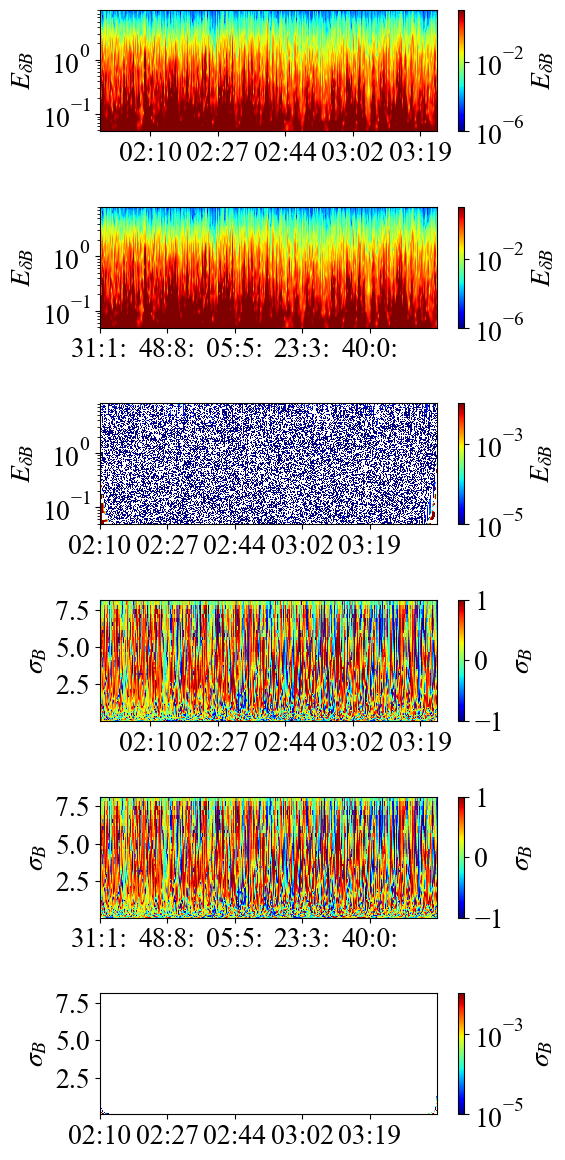

In [ ]:
### Compare shifted wavelet outputs

fig,ax=plt.subplots(6,1,figsize=(6,12))

## 1. First wavelet
pcm1=ax[0].pcolormesh(df1.index[int(t2[0]-t1[0]):],freqs,(eb_fluc[0][:,int(t2[0]-t1[0]):]),norm=colors.LogNorm(vmin=1e-6,vmax=1e1), cmap='jet',rasterized=True)
cbar=fig.colorbar(pcm1, ax=ax[0])
cbar.set_label(r'$E_{\delta B}$',rotation=90)
ticklocs,ticklabels = tasteful_ticks(tB_solo[t1[0]:t1[1]])
ax[0].set_ylabel(r'$E_{\delta B}$')
ax[0].set_yscale('log')
ax[0].set_xticklabels(ticklabels)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))

## 2. Second wavelet
pcm1=ax[1].pcolormesh(df2.index[:-int(t2[0]-t1[0])],freqs,(eb_fluc[1][:,:-int(t2[0]-t1[0])]),norm=colors.LogNorm(vmin=1e-6,vmax=1e1), cmap='jet',rasterized=True)
cbar=fig.colorbar(pcm1, ax=ax[1])
cbar.set_label(r'$E_{\delta B}$',rotation=90)
ticklocs,ticklabels = tasteful_ticks(tB_solo[t2[0]:t2[1]])
ax[1].set_ylabel(r'$E_{\delta B}$')
ax[1].set_yscale('log')
ax[1].set_xticklabels(ticklabels)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(5))

## 3. Difference of first and second wavelets normalized by average wavelet power
pcm1=ax[2].pcolormesh(df2.index[:-int(t2[0]-t1[0])],freqs,2*(eb_fluc[1][:,:-int(t2[0]-t1[0])] - eb_fluc[0][:,int(t2[0]-t1[0]):])/(eb_fluc[1][:,:-int(t2[0]-t1[0])] + eb_fluc[0][:,int(t2[0]-t1[0]):]), norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap='jet',rasterized=True)
cbar=fig.colorbar(pcm1, ax=ax[2])
cbar.set_label(r'$E_{\delta B}$',rotation=90)
ticklocs,ticklabels = tasteful_ticks(tB_solo[t1[0]:t1[1]])
ax[2].set_ylabel(r'$E_{\delta B}$')
ax[2].set_yscale('log')
ax[2].set_xticklabels(ticklabels)
ax[2].xaxis.set_major_locator(plt.MaxNLocator(5))

## 4. First helicity
pcm1=ax[3].pcolormesh(df1.index[int(t2[0]-t1[0]):],freqs,(sigm[0][:,int(t2[0]-t1[0]):]),vmin=-1,vmax=1, cmap='jet',rasterized=True)
cbar=fig.colorbar(pcm1, ax=ax[3])
cbar.set_label(r'$\sigma_B$',rotation=90)
ticklocs,ticklabels = tasteful_ticks(tB_solo[t1[0]:t1[1]])
ax[3].set_ylabel(r'$\sigma_B$')
ax[3].set_xticklabels(ticklabels)
ax[3].xaxis.set_major_locator(plt.MaxNLocator(5))

## 2. Second helicity
pcm1=ax[4].pcolormesh(df2.index[:-int(t2[0]-t1[0])],freqs,(sigm[1][:,:-int(t2[0]-t1[0])]),vmin=-1,vmax=1, cmap='jet',rasterized=True)
cbar=fig.colorbar(pcm1, ax=ax[4])
cbar.set_label(r'$\sigma_B$',rotation=90)
ticklocs,ticklabels = tasteful_ticks(tB_solo[t2[0]:t2[1]])
ax[4].set_ylabel(r'$\sigma_B$')
ax[4].set_xticklabels(ticklabels)
ax[4].xaxis.set_major_locator(plt.MaxNLocator(5))

## 3. Difference of first and second helicities normalized by average wavelet power
pcm1=ax[5].pcolormesh(df2.index[:-int(t2[0]-t1[0])],freqs,2*(sigm[1][:,:-int(t2[0]-t1[0])] - sigm[0][:,int(t2[0]-t1[0]):])/(sigm[1][:,:-int(t2[0]-t1[0])] + sigm[0][:,int(t2[0]-t1[0]):]), norm=colors.LogNorm(vmin=1e-5,vmax=1e-2),cmap='jet',rasterized=True)
cbar=fig.colorbar(pcm1, ax=ax[5])
cbar.set_label(r'$\sigma_B$',rotation=90)
ticklocs,ticklabels = tasteful_ticks(tB_solo[t1[0]:t1[1]])
ax[5].set_ylabel(r'$\sigma_B$')
ax[5].set_xticklabels(ticklabels)
ax[5].xaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()


In [ ]:
a = np.array([1,2,3])
b = np.array([4,5,6])
c = np.array([7,8,9])
print(np.vstack((a,b,c))[0])

[1 2 3]


<>:27: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:32: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:32: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
/var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_6904/3293701793.py:27: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if np is 0:
/var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_6904/3293701793.py:32: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if V is 0:


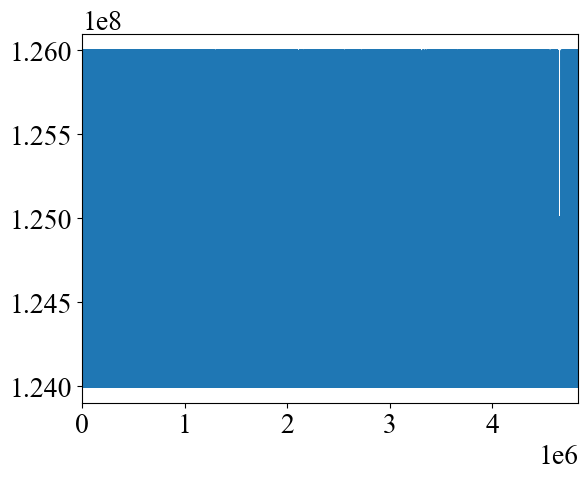

In [ ]:
plt.plot(np.diff(tB_solo))

In [ ]:
### Plot long interval of SolO magnetic field using wavelet2Long

B_for_wavelet = np.vstack((Bx_solo,By_solo,Bz_solo))

delta_t = 1/8
t_len = int(120*60*1/delta_t)
full_t_len = np.arange(0,tB_solo.size,1)
ratio_COI = 0.2
t_ind_chunks = chunk(full_t_len,chunksize = t_len,stepsize = int(t_len*(1-2*ratio_COI)))

fig,ax=plt.subplots(2,1,figsize=(20,10))
for k in range(len(t_ind_chunks)):
    
    t_range = (t_ind_chunks[k][0],t_ind_chunks[k][-1]) ### (first,last) indices of time for full wavelet

    t_plot,freqs_plot,eb_fluc_plot,sigm_plot = wavelet2Long(t_range,B_for_wavelet,f_n = 128,f_min=1e-2,f_max=4,delta_t=delta_t)
    
    ## truncate wavelet transforms to correct index range (eb_fluc+sigm have same length as t_range, but different starting/ending index)
    pcm1=ax[0].pcolormesh(full_t_len[t_plot[0]:t_plot[1]],freqs_plot,(eb_fluc_plot[:,t_plot[0]-t_range[0]:t_plot[1]-t_range[0]]),norm=colors.LogNorm(vmin=1e-6,vmax=1e1), cmap='jet',rasterized=True)
    pcm2=ax[1].pcolormesh(full_t_len[t_plot[0]:t_plot[1]],freqs_plot,(sigm_plot[:,t_plot[0]-t_range[0]:t_plot[1]-t_range[0]]),vmin=-1,vmax=1, cmap='jet',rasterized=True)
    if k % 20 is 0:
        print('Complete: ' + str(t_plot) + ' from total length ' + str(full_t_len))

cbar=fig.colorbar(pcm1, ax=ax[0])
cbar.set_label(r'$E_{\delta B}$',rotation=90)
cbar=fig.colorbar(pcm2, ax=ax[1])

cbar.set_label(r'$\sigma_M$',rotation=90)
ticklocs,ticklabels = tasteful_ticks(tB_solo[0:t_range[1]])

ax[0].set_ylabel(r'$E_{\delta B}$')
ax[0].set_yscale('log')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[0].set_xticklabels(ticklabels)
ax[1].set_ylabel(r'$\sigma_M$')
ax[1].set_yscale('log')
ax[1].set_xticklabels(ticklabels)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(5))

plt.savefig('/Users/sfordin/Documents/Science-Projects/01-psp-wind-conjunction/figures/fig wavelets SolO.pdf',format='pdf')


24-Sep-25 03:34:50: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(11519, 46079) from total length 4838453


24-Sep-25 03:35:08: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(46079, 80639) from total length 4838453


24-Sep-25 03:35:26: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(80639, 115199) from total length 4838453


24-Sep-25 03:35:44: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(115199, 149759) from total length 4838453


24-Sep-25 03:36:03: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(149759, 184319) from total length 4838453


24-Sep-25 03:36:21: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(184319, 218879) from total length 4838453


24-Sep-25 03:36:39: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(218879, 253439) from total length 4838453


24-Sep-25 03:36:57: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(253439, 287999) from total length 4838453


24-Sep-25 03:37:14: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(287999, 322559) from total length 4838453


24-Sep-25 03:37:33: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(322559, 357119) from total length 4838453


24-Sep-25 03:37:50: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(357119, 391679) from total length 4838453


24-Sep-25 03:38:08: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(391679, 426239) from total length 4838453


24-Sep-25 03:38:26: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(426239, 460799) from total length 4838453


24-Sep-25 03:38:44: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(460799, 495359) from total length 4838453


24-Sep-25 03:39:02: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(495359, 529919) from total length 4838453


24-Sep-25 03:39:20: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(529919, 564479) from total length 4838453


24-Sep-25 03:39:38: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(564479, 599039) from total length 4838453


24-Sep-25 03:39:55: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(599039, 633599) from total length 4838453


24-Sep-25 03:40:13: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(633599, 668159) from total length 4838453


24-Sep-25 03:40:31: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(668159, 702719) from total length 4838453


24-Sep-25 03:40:49: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(702719, 737279) from total length 4838453


24-Sep-25 03:41:07: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(737279, 771839) from total length 4838453


24-Sep-25 03:41:25: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(771839, 806399) from total length 4838453


24-Sep-25 03:41:43: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(806399, 840959) from total length 4838453


24-Sep-25 03:42:00: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(840959, 875519) from total length 4838453


24-Sep-25 03:42:19: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(875519, 910079) from total length 4838453


24-Sep-25 03:42:36: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(910079, 944639) from total length 4838453


24-Sep-25 03:42:54: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(944639, 979199) from total length 4838453


24-Sep-25 03:43:11: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(979199, 1013759) from total length 4838453


24-Sep-25 03:43:29: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1013759, 1048319) from total length 4838453


24-Sep-25 03:43:47: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1048319, 1082879) from total length 4838453


24-Sep-25 03:44:04: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1082879, 1117439) from total length 4838453


24-Sep-25 03:44:22: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1117439, 1151999) from total length 4838453


24-Sep-25 03:44:40: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1151999, 1186559) from total length 4838453


24-Sep-25 03:44:58: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1186559, 1221119) from total length 4838453


24-Sep-25 03:45:16: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1221119, 1255679) from total length 4838453


24-Sep-25 03:45:34: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1255679, 1290239) from total length 4838453


24-Sep-25 03:45:51: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1290239, 1324799) from total length 4838453


24-Sep-25 03:46:09: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1324799, 1359359) from total length 4838453


24-Sep-25 03:46:27: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1359359, 1393919) from total length 4838453


24-Sep-25 03:46:45: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1393919, 1428479) from total length 4838453


24-Sep-25 03:47:03: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1428479, 1463039) from total length 4838453


24-Sep-25 03:47:21: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1463039, 1497599) from total length 4838453


24-Sep-25 03:47:39: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1497599, 1532159) from total length 4838453


24-Sep-25 03:47:56: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1532159, 1566719) from total length 4838453


24-Sep-25 03:48:14: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1566719, 1601279) from total length 4838453


24-Sep-25 03:48:32: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1601279, 1635839) from total length 4838453


24-Sep-25 03:48:50: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1635839, 1670399) from total length 4838453


24-Sep-25 03:49:07: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1670399, 1704959) from total length 4838453


24-Sep-25 03:49:25: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1704959, 1739519) from total length 4838453


24-Sep-25 03:49:43: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1739519, 1774079) from total length 4838453


24-Sep-25 03:50:00: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1774079, 1808639) from total length 4838453


24-Sep-25 03:50:18: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1808639, 1843199) from total length 4838453


24-Sep-25 03:50:36: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1843199, 1877759) from total length 4838453


24-Sep-25 03:50:53: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1877759, 1912319) from total length 4838453


24-Sep-25 03:51:11: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1912319, 1946879) from total length 4838453


24-Sep-25 03:51:29: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1946879, 1981439) from total length 4838453


24-Sep-25 03:51:47: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(1981439, 2015999) from total length 4838453


24-Sep-25 03:52:05: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2015999, 2050559) from total length 4838453


24-Sep-25 03:52:23: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2050559, 2085119) from total length 4838453


24-Sep-25 03:52:41: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2085119, 2119679) from total length 4838453


24-Sep-25 03:52:59: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2119679, 2154239) from total length 4838453


24-Sep-25 03:53:17: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2154239, 2188799) from total length 4838453


24-Sep-25 03:53:35: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2188799, 2223359) from total length 4838453


24-Sep-25 03:53:53: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2223359, 2257919) from total length 4838453


24-Sep-25 03:54:10: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2257919, 2292479) from total length 4838453


24-Sep-25 03:54:28: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2292479, 2327039) from total length 4838453


24-Sep-25 03:54:46: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2327039, 2361599) from total length 4838453


24-Sep-25 03:55:03: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2361599, 2396159) from total length 4838453


24-Sep-25 03:55:21: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2396159, 2430719) from total length 4838453


24-Sep-25 03:55:39: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2430719, 2465279) from total length 4838453


24-Sep-25 03:55:57: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2465279, 2499839) from total length 4838453


24-Sep-25 03:56:14: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2499839, 2534399) from total length 4838453


24-Sep-25 03:56:32: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2534399, 2568959) from total length 4838453


24-Sep-25 03:56:50: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2568959, 2603519) from total length 4838453


24-Sep-25 03:57:07: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2603519, 2638079) from total length 4838453


24-Sep-25 03:57:25: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2638079, 2672639) from total length 4838453


24-Sep-25 03:57:43: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2672639, 2707199) from total length 4838453


24-Sep-25 03:58:00: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2707199, 2741759) from total length 4838453


24-Sep-25 03:58:18: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2741759, 2776319) from total length 4838453


24-Sep-25 03:58:36: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2776319, 2810879) from total length 4838453


24-Sep-25 03:58:54: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2810879, 2845439) from total length 4838453


24-Sep-25 03:59:11: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2845439, 2879999) from total length 4838453


24-Sep-25 03:59:29: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2879999, 2914559) from total length 4838453


24-Sep-25 03:59:46: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2914559, 2949119) from total length 4838453


24-Sep-25 04:00:04: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2949119, 2983679) from total length 4838453


24-Sep-25 04:00:22: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(2983679, 3018239) from total length 4838453


24-Sep-25 04:00:39: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3018239, 3052799) from total length 4838453


24-Sep-25 04:00:57: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3052799, 3087359) from total length 4838453


24-Sep-25 04:01:15: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3087359, 3121919) from total length 4838453


24-Sep-25 04:01:32: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3121919, 3156479) from total length 4838453


24-Sep-25 04:01:50: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3156479, 3191039) from total length 4838453


24-Sep-25 04:02:08: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3191039, 3225599) from total length 4838453


24-Sep-25 04:02:25: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3225599, 3260159) from total length 4838453


24-Sep-25 04:02:43: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3260159, 3294719) from total length 4838453


24-Sep-25 04:03:01: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3294719, 3329279) from total length 4838453


24-Sep-25 04:03:18: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3329279, 3363839) from total length 4838453


24-Sep-25 04:03:36: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3363839, 3398399) from total length 4838453


24-Sep-25 04:03:53: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3398399, 3432959) from total length 4838453


24-Sep-25 04:04:11: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3432959, 3467519) from total length 4838453


24-Sep-25 04:04:29: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3467519, 3502079) from total length 4838453


24-Sep-25 04:04:46: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3502079, 3536639) from total length 4838453


24-Sep-25 04:05:04: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3536639, 3571199) from total length 4838453


24-Sep-25 04:05:22: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3571199, 3605759) from total length 4838453


24-Sep-25 04:05:39: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3605759, 3640319) from total length 4838453


24-Sep-25 04:05:57: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3640319, 3674879) from total length 4838453


24-Sep-25 04:06:15: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3674879, 3709439) from total length 4838453


24-Sep-25 04:06:32: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3709439, 3743999) from total length 4838453


24-Sep-25 04:06:50: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3743999, 3778559) from total length 4838453


24-Sep-25 04:07:08: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3778559, 3813119) from total length 4838453


24-Sep-25 04:07:26: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3813119, 3847679) from total length 4838453


24-Sep-25 04:07:43: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3847679, 3882239) from total length 4838453


24-Sep-25 04:08:01: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3882239, 3916799) from total length 4838453


24-Sep-25 04:08:18: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3916799, 3951359) from total length 4838453


24-Sep-25 04:08:36: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3951359, 3985919) from total length 4838453


24-Sep-25 04:08:54: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(3985919, 4020479) from total length 4838453


24-Sep-25 04:09:12: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4020479, 4055039) from total length 4838453


24-Sep-25 04:09:29: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4055039, 4089599) from total length 4838453


24-Sep-25 04:09:47: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4089599, 4124159) from total length 4838453


24-Sep-25 04:10:05: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4124159, 4158719) from total length 4838453


24-Sep-25 04:10:22: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4158719, 4193279) from total length 4838453


24-Sep-25 04:10:40: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4193279, 4227839) from total length 4838453


24-Sep-25 04:10:57: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4227839, 4262399) from total length 4838453


24-Sep-25 04:11:15: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4262399, 4296959) from total length 4838453


24-Sep-25 04:11:33: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4296959, 4331519) from total length 4838453


24-Sep-25 04:11:51: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4331519, 4366079) from total length 4838453


24-Sep-25 04:12:08: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4366079, 4400639) from total length 4838453


24-Sep-25 04:12:26: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4400639, 4435199) from total length 4838453


24-Sep-25 04:12:44: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4435199, 4469759) from total length 4838453


24-Sep-25 04:13:01: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4469759, 4504319) from total length 4838453


24-Sep-25 04:13:19: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4504319, 4538879) from total length 4838453


24-Sep-25 04:13:37: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4538879, 4573439) from total length 4838453


24-Sep-25 04:13:54: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4573439, 4607999) from total length 4838453


24-Sep-25 04:14:12: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4607999, 4642559) from total length 4838453


24-Sep-25 04:14:30: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4642559, 4677119) from total length 4838453


24-Sep-25 04:14:47: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4677119, 4711679) from total length 4838453


24-Sep-25 04:15:05: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4711679, 4746239) from total length 4838453


24-Sep-25 04:15:22: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4746239, 4780799) from total length 4838453


24-Sep-25 04:15:40: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/4024338448.py:80: RuntimeWarning: invalid value encountered in divide
  sigm = a/b



Complete:(4780799, 4815359) from total length 4838453


24-Sep-25 04:15:46: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/3077091782.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ticklabels)

24-Sep-25 04:15:46: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_9101/3077091782.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ticklabels)



In [ ]:
### Plot long interval of Wind magnetic field using wavelet2Long

B_for_wavelet = np.vstack((Bx,By,Bz))

delta_t = 1/11
t_len = int(120*60*1/delta_t)
full_t_len = np.arange(0,tB.size,1)
ratio_COI = 0.2
t_ind_chunks = chunk(full_t_len,chunksize = t_len,stepsize = int(t_len*(1-2*ratio_COI)))

fig,ax=plt.subplots(2,1,figsize=(20,10))

for k in range(len(t_ind_chunks)):

    t_range = (t_ind_chunks[k][0],t_ind_chunks[k][-1]) ### (first,last) indices of time for full wavelet
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        t_plot,freqs_plot,eb_fluc_plot,sigm_plot = wavelet2Long(t_range,B_for_wavelet,f_n = 128,f_min=1e-2,f_max=5.5,delta_t = delta_t)
    
    ## truncate wavelet transforms to correct index range (eb_fluc+sigm have same length as t_range, but different starting/ending index)
    pcm1=ax[0].pcolormesh(full_t_len[t_plot[0]:t_plot[1]],freqs_plot,(eb_fluc_plot[:,t_plot[0]-t_range[0]:t_plot[1]-t_range[0]]),norm=colors.LogNorm(vmin=1e-6,vmax=1e1), cmap='jet',rasterized=True)
    pcm2=ax[1].pcolormesh(full_t_len[t_plot[0]:t_plot[1]],freqs_plot,(sigm_plot[:,t_plot[0]-t_range[0]:t_plot[1]-t_range[0]]),vmin=-1,vmax=1, cmap='jet',rasterized=True)
    if k % 20 is 0:
        print('Complete: ' + str(t_plot) + ' from total length ' + str(full_t_len.size) + ', ' + str(time.time()))
cbar=fig.colorbar(pcm1, ax=ax[0])
cbar.set_label(r'$E_{\delta B}$',rotation=90)

cbar=fig.colorbar(pcm2, ax=ax[1])
cbar.set_label(r'$\sigma_M$',rotation=90)

ticklocs,ticklabels = tasteful_ticks(tB[0:t_range[1]])

ax[0].set_ylabel(r'$E_{\delta B}$')
# ax[0].set_xticks(ticklocs)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[0].set_xticklabels(ticklabels)
ax[0].set_yscale('log')

ax[1].set_ylabel(r'$\sigma_M$')
# ax[1].set_xticks(ticklocs)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[1].set_xticklabels(ticklabels)
ax[1].set_yscale('log')

plt.savefig('/Users/sfordin/Documents/Science-Projects/01-psp-wind-conjunction/figures/fig wavelets Wind.png',format='png')


25-Sep-25 15:52:31: <>:23: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?

25-Sep-25 15:52:31: <>:23: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?

25-Sep-25 15:52:31: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_935/1283360024.py:23: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if k % 20 is 0:



Complete: (15839, 63359) from total length 4649160, 1758829982.192854
Complete: (966239, 1013759) from total length 4649160, 1758830607.182782
Complete: (1916639, 1964159) from total length 4649160, 1758831228.138266
Complete: (2867039, 2914559) from total length 4649160, 1758831855.2261271
Complete: (3817439, 3864959) from total length 4649160, 1758832474.963372


25-Sep-25 16:44:48: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_935/1283360024.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ticklabels)

25-Sep-25 16:44:49: /var/folders/gb/t01ldmr50zj5_9vxcxzwk42h0000gp/T/ipykernel_935/1283360024.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ticklabels)



Error in callback <function flush_figures at 0x144d409a0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

25-Aug-25 13:33:44: <ipython-input-17-ebd2a28bb84b>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ticklabels)

25-Aug-25 13:33:56: <ipython-input-17-ebd2a28bb84b>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ticklabels)



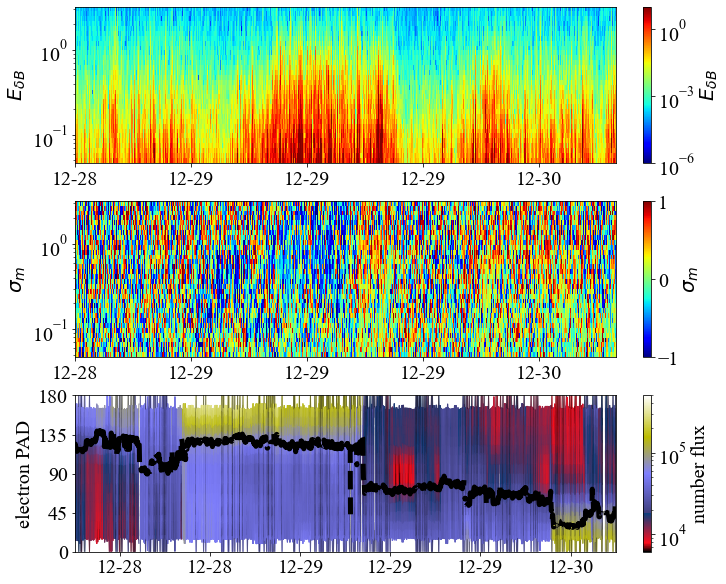

In [ ]:
### Plot wavelet


### Plotting time
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.family': 'Times New Roman'})


# med_filter_len = 49

# phi_B_ds = resample(phi_B,new_times=t3pad,times=tB)[1] # resample phi_B at same cadence as PADs
# phi_B_median = scipy.signal.medfilt(phi_B_ds,kernel_size = med_filter_len)

# theta_B_ds = resample(theta_B,new_times=t3pad,times=tB)[1] # resample phi_B at same cadence as PADs
# theta_B_median = scipy.signal.medfilt(theta_B_ds,kernel_size = med_filter_len)

# hcs_sb,hcs_regions = hcs_loc(t3pad,tB,electronflux,phi_B,med_filter_len=med_filter_len,buffer_range=0,return_bounds=True)
# hcs_walls = strahl_walls(electronflux,pangle,region_inds=hcs_regions)

# rot_bounds,rot_mids = autochord(phi_B_median)

# # for j in range(len(rot_times)):
# #     plt.scatter(rot_bounds[j][0],phi_B_median[rot_bounds[j][0]],c='green',s=100)
# #     plt.scatter(rot_bounds[j][1],phi_B_median[rot_bounds[j][1]],c='green',s=100)
# t3pad_mesh = np.expand_dims(t3pad,axis=0)
# t3pad_mesh = np.repeat(t3pad_mesh,8,axis=0).T
# cmap_min = np.max([np.ma.min(electronflux[:,:,4][electronflux[:,:,4] > 0]),1e3])
# cmap_max = np.min([np.ma.max(electronflux[:,:,4][electronflux[:,:,4] > 0]),4e5])
    
# epad_norm = np.zeros(epad.shape)
# epad_med_norm = np.zeros(epad.shape)
# for k in range(epad.shape[0]):
#     epad_ma = np.ma.array(epad[k,:],mask=epad[k,:] == 0)
#     col_sum = np.ma.sum(epad[k,:])
#     epad_norm[k,:] = epad_ma/col_sum if col_sum > 0 else 0

#     epad_ma = np.ma.array(epad_med[k,:],mask=epad_med[k,:] == 0)
#     col_sum = np.ma.sum(epad_med[k,:])
#     epad_med_norm[k,:] = epad_ma/col_sum if col_sum > 0 else 0
    

# # plot_list = ['Bmag','phi_B','ni','Vmag']
# plot_list = []
# n = len(plot_list)
ticklocs,ticklabels = tasteful_ticks(t3pad)

fig,ax=plt.subplots(3,1,figsize=(10,8),layout='compressed')

# wavelet
pcm1=ax[0].pcolormesh(df.index,freqs,(eb_fluc),norm=colors.LogNorm(vmin=1e-6,vmax=1e1), cmap='jet',rasterized=True)
cbar=fig.colorbar(pcm1, ax=ax[0])
cbar.set_label(r'$E_{\delta B}$',rotation=90)
ticklocs,ticklabels = tasteful_ticks(tB)
ax[0].set_ylabel(r'$E_{\delta B}$')
ax[0].set_yscale('log')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[0].set_xticklabels(ticklabels)

# sigm
pcm2=ax[1].pcolormesh(df.index,freqs,(sigm),vmin=-1,vmax=1, cmap='jet',rasterized=True)
cbar=fig.colorbar(pcm2, ax=ax[1])
cbar.set_label(r'$\sigma_m$', rotation=90)
ax[1].set_ylabel(r'$\sigma_m$')
ax[1].set_yscale('log')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[1].set_xticklabels(ticklabels)



### pad 
t3pad_mesh = np.expand_dims(t3pad,axis=0)
t3pad_mesh = np.repeat(t3pad_mesh,8,axis=0).T
pangles = np.linspace(0,180,8)
cmap_min = np.ma.min(electronflux[:,:,4][electronflux[:,:,4]>0])
cmap_max = np.min([np.ma.max(electronflux[:,:,4][electronflux[:,:,4]>0]),10**6])

pcm3=ax[2].pcolormesh(t3pad_mesh,pangle,(electronflux[:,:,4]),cmap='gist_stern',norm=colors.LogNorm(vmin=cmap_min,vmax=5e5),shading='gouraud')

ax[2].set_ylabel(r'electron PAD')
ax[2].set_ylim([0,180])
ax[2].set_yticks([0,45,90,135,180])


ticklocs,ticklabels = tasteful_ticks(t3pad)
ax[2].set_xticks(ticklocs)
ax[2].set_xticklabels(ticklabels)
# ax[2].set_xlim(t3pad[int(len(t3pad)/2)],t3pad[-1])

cbar=fig.colorbar(pcm3, ax=ax[2])
cbar.set_label('number flux', rotation=90)

pangle_centroid = np.repeat(np.expand_dims(pangles,1),t3pad.shape[0],1).T
centroids_epad = np.ma.average(pangle_centroid,weights=electronflux[:,:,4],axis=1)
ax[2].plot(t3pad,centroids_epad,color='k',ls='--',lw=5)

# for j in hcs_sb[0]:
#     ax[2].axvline(t3pad[j],ls='--',c='blue',lw=4)

# for i in range(len(hcs_regions)):
#     ax[0].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='k',alpha=0.1)
#     ax[1].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='k',alpha=0.1)
#     ax[2].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='k',alpha=0.1)

# for i in hcs_walls:
#     ax[0].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='g',alpha=0.1)
#     ax[1].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='g',alpha=0.1)
#     ax[2].axvspan(t3pad[hcs_regions[i][0]],t3pad[hcs_regions[i][-1]],color='g',alpha=0.1)

# for i in range(0,n-1):
#     var_name = plot_list[i]

#     t_name = epoch_choice[var_name]
#     var_ass = var_dict[var_name]
#     t_ass = var_dict[t_name]

#     plot_label = label_dict[var_name]
#     lt = np.shape(t_ass)[0]

#     if n > 1:
#         ax[i+3].plot(t_ass,var_ass,label='{}'.format(plot_label))
#         ax[i+3].set_xticks(ticklocs)
#         ax[i+3].set_xticklabels(ticklabels)
#         ax[i+3].locator_params(axis='x', nbins=6)
#         ax[i+3].set_ylabel(r'{}'.format(plot_label))
#         ax[i+3].yaxis.set_minor_locator(AutoMinorLocator(n = 5))
#         if var_name == 'phi_B':
#             ax[i+3].set_ylim([0,360])
#             ax[i+3].set_yticks([0,90,180,270,360])
#         if var_name == 'Tperpp':
#             ax[i+3].plot(t_ass,var_dict['Tparp'],color='orange',label=r'{}'.format(label_dict['Tparp']))
#             ax[i+3].set_ylabel(r'$T_p$ (eV)')

#         if var_name =='Tparp':
#             ax[i+3].plot(t_ass,var_dict['Tperpp'],color='orange',label=r'{}'.format(label_dict['Tperpp']))
#     else:
#         ax[3].plot(t_ass,var_ass,label='{}'.format(var_name))
#         ax[3].set_xticks([t_ass[0],t_ass[int(lt/4)],t_ass[int(lt/2)],t_ass[int(3*lt/4)],t_ass[int(lt)-1]])
#         ax[3].locator_params(axis='x', nbins=6)
#         ax[3].set_ylabel('{}'.format(plot_label))

# ax[-1].legend()
# ax[-1].set_xticks(ticklocs)

# ax[-1].set_xticklabels(ticklabels)



plt.savefig('wavelet stats 082525, days = {}, zoom.pdf'.format(days),format='pdf',bbox_inches='tight')


30-Jul-25 16:03:37: <ipython-input-60-e1f2b6832949>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ticklabels)

30-Jul-25 16:03:44: <ipython-input-60-e1f2b6832949>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ticklabels)



IndexError: index 1824 is out of bounds for axis 0 with size 857

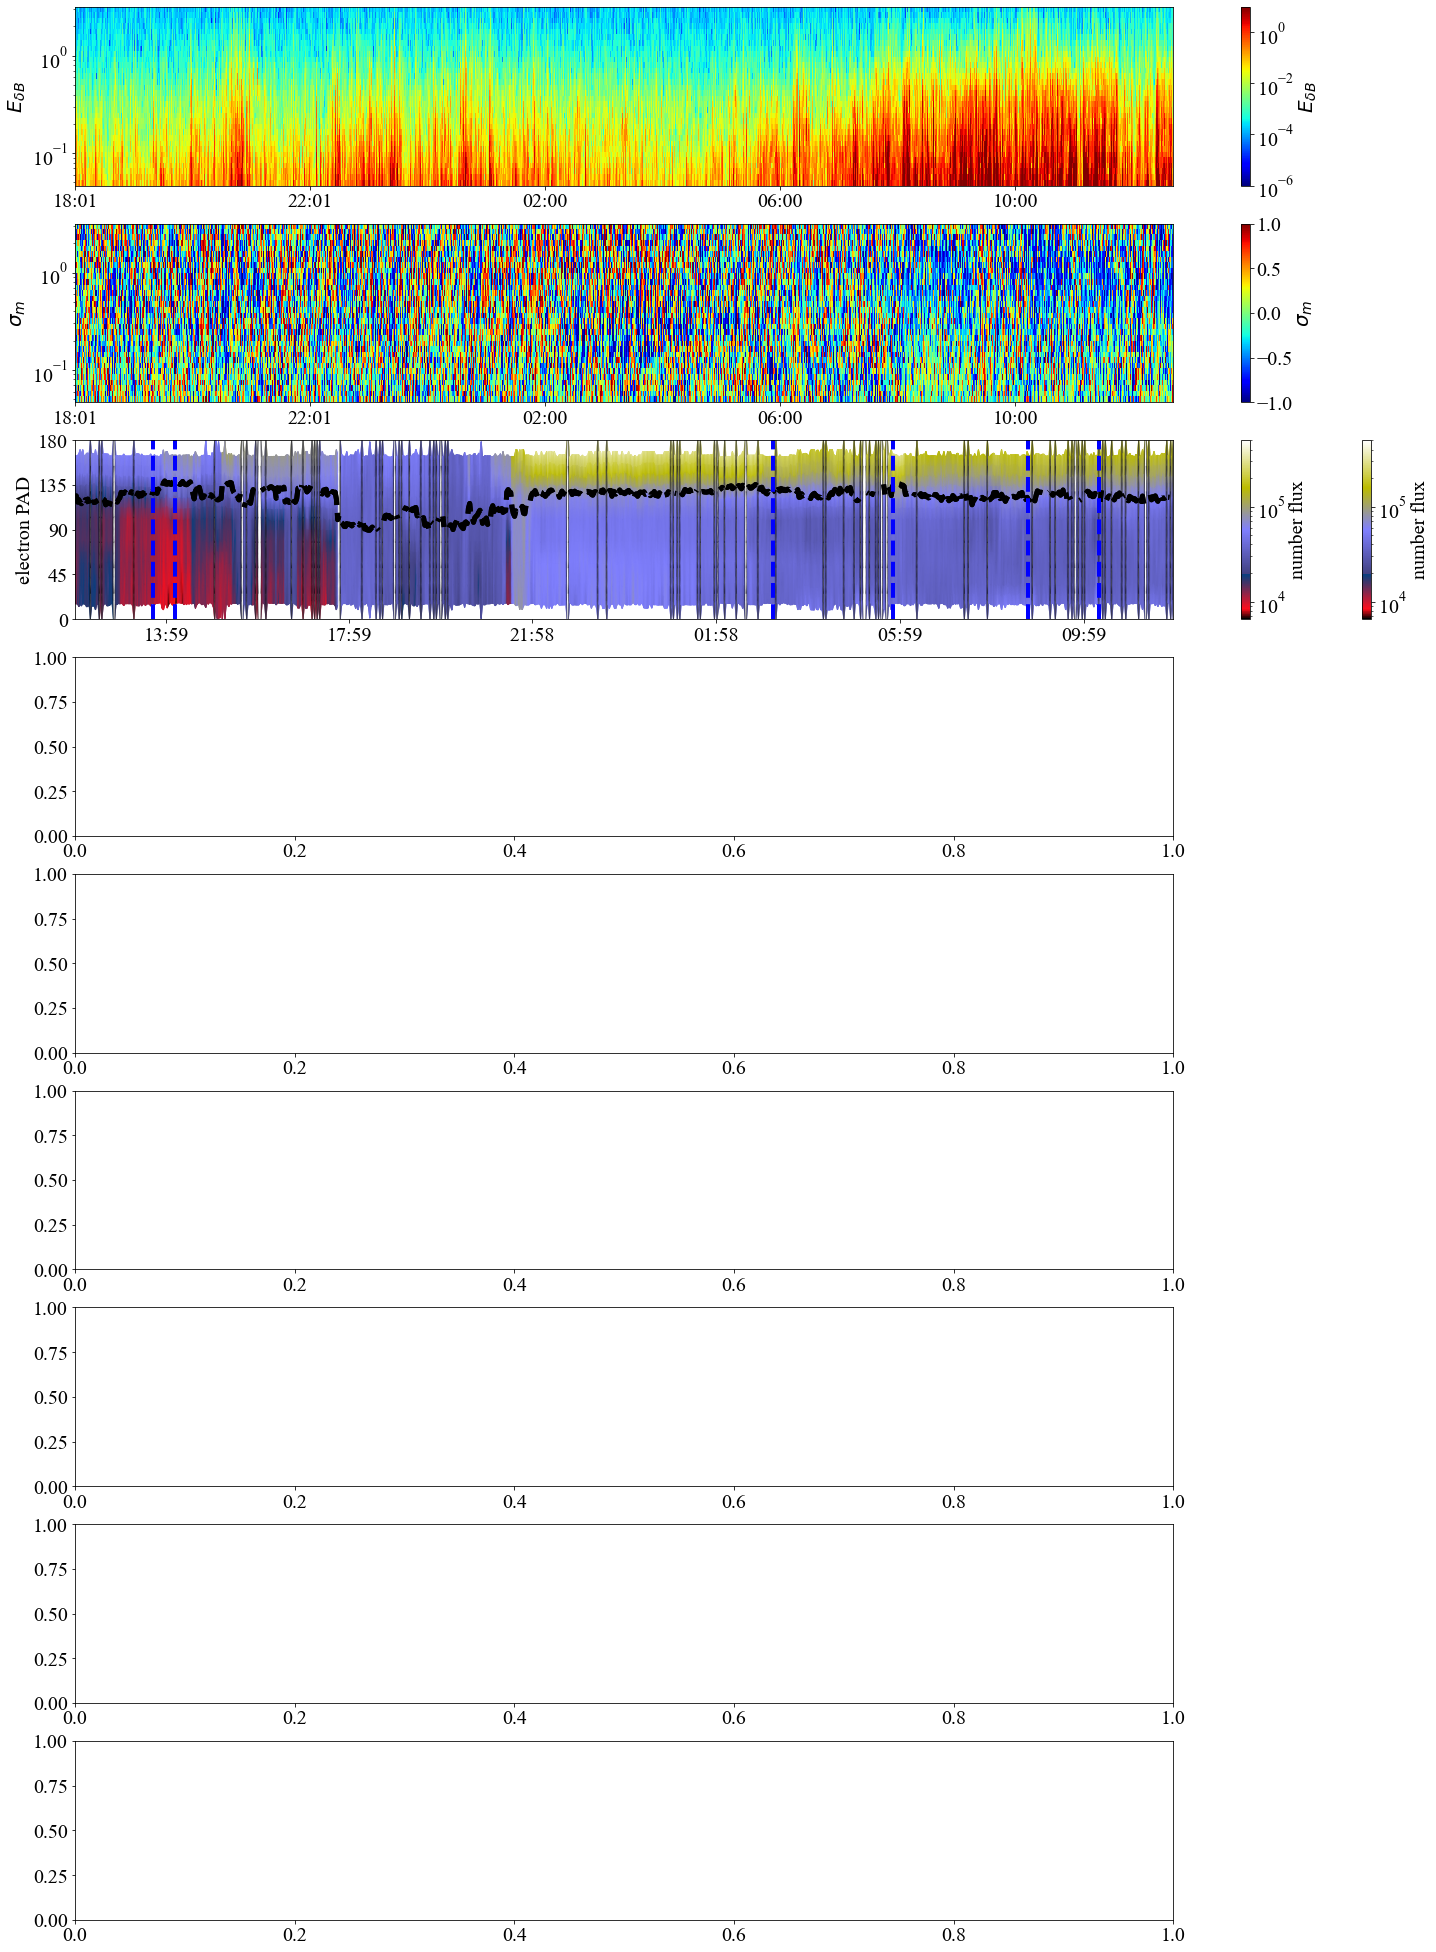

In [ ]:
### Plot wavelet


### Plotting time
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.family': 'Times New Roman'})

plot_list = ['Bmag','Bx','By','Bz','ni','Vmag','Tperpp']
n = len(plot_list)
ticklocs,ticklabels = tasteful_ticks(t3pad)

fig,ax=plt.subplots(n+3-1,1,figsize=(20,6 + 3 * n),layout='compressed')
### Plotting time
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.family': 'Times New Roman'})

# plot_list = ['Bmag','phi_B','ni','Vmag']
plot_list = []
n = len(plot_list)
ticklocs,ticklabels = tasteful_ticks(t3pad)

# fig,ax=plt.subplots(3,1,figsize=(20,6 + 3 * n),layout='compressed')

# wavelet
# ax[0].set_xlim(len(tB)/2,len(tB))
# pcm1=ax[0].pcolormesh(df.index,freqs,(eb_fluc),norm=colors.LogNorm(vmin=1e-6,vmax=1e1), cmap='jet',rasterized=True)
# cbar=fig.colorbar(pcm1, ax=ax[0])
# cbar.set_label(r'$E_{\delta B}$',rotation=90)
# ticklocs,ticklabels = tasteful_ticks(tB)
# ax[0].set_ylabel(r'$E_{\delta B}$')
# ax[0].set_yscale('log')
# ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
# ax[0].set_xticklabels(ticklabels)

# # sigm
# # ax[1].set_xlim(len(tB)/2,len(tB))
# pcm2=ax[1].pcolormesh(df.index,freqs,(sigm),vmin=-1,vmax=1, cmap='jet',rasterized=True)
# cbar=fig.colorbar(pcm2, ax=ax[1])
# cbar.set_label(r'$\sigma_m$', rotation=90)
# ax[1].set_ylabel(r'$\sigma_m$')
# ax[1].set_yscale('log')
# ax[1].xaxis.set_major_locator(plt.MaxNLocator(5))
# ax[1].set_xticklabels(ticklabels)



# ### pad 
# t3pad_mesh = np.expand_dims(t3pad,axis=0)
# t3pad_mesh = np.repeat(t3pad_mesh,8,axis=0).T
# pangles = np.linspace(0,180,8)
# cmap_min = np.ma.min(electronflux[:,:,4][electronflux[:,:,4]>0])
# cmap_max = np.min([np.ma.max(electronflux[:,:,4][electronflux[:,:,4]>0]),10**6])

# pcm3=ax[2].pcolormesh(t3pad_mesh,pangle,(electronflux[:,:,4]),cmap='gist_stern',norm=colors.LogNorm(vmin=cmap_min,vmax=5e5),shading='gouraud')

# ax[2].set_ylabel(r'electron PAD')
# ax[2].set_ylim([0,180])
# ax[2].set_yticks([0,45,90,135,180])


# ticklocs,ticklabels = tasteful_ticks(t3pad)
# ax[2].set_xticks(ticklocs)
# ax[2].set_xticklabels(ticklabels)
# # ax[2].set_xlim(t3pad[int(len(t3pad)/2)],t3pad[-1])

# cbar=fig.colorbar(pcm3, ax=ax[2])
# cbar.set_label('number flux', rotation=90)

# pangle_centroid = np.repeat(np.expand_dims(pangles,1),t3pad.shape[0],1).T
# centroids_epad = np.ma.average(pangle_centroid,weights=electronflux[:,:,4],axis=1)
# ax[2].plot(t3pad,centroids_epad,color='k',ls='--',lw=5)




# pad

# t3pad_mesh = np.expand_dims(t3pad,axis=0)
# t3pad_mesh = np.repeat(t3pad_mesh,8,axis=0).T
# pangles = np.linspace(0,180,8)
# cmap_min = np.ma.min(electronflux[:,:,4][electronflux[:,:,4]>0])
# cmap_max = np.min([np.ma.max(electronflux[:,:,4][electronflux[:,:,4]>0]),10**6])

# pcm3=ax[2].pcolormesh(t3pad_mesh,pangle,(electronflux[:,:,4]),cmap='gist_stern',norm=colors.LogNorm(vmin=cmap_min,vmax=5e5),shading='gouraud')
# ax[2].set_ylabel(r'electron PAD')
# # ax[2].set_xticks([0,len(t3pad)/4,len(t3pad)/2,3*len(t3pad)/4,len(t3pad)])
# ax[2].set_xticklabels(['' for i in range(ax[2].get_xticks().shape[0])]);
# ax[2].set_ylim([0,180])
# ax[2].set_yticks([0,45,90,135,180])
# ax[2].set_xticks(ticklocs)
# ax[2].set_xticklabels(ticklabels)


# ax[2].set_xlim([t3pad[int(t3pad.size/2)],t3pad[-1]])


cbar=fig.colorbar(pcm3, ax=ax[2])
cbar.set_label('number flux', rotation=90)

pangle_centroid = np.repeat(np.expand_dims(pangles,1),t3pad.shape[0],1).T
centroids_epad = np.ma.average(pangle_centroid,weights=electronflux[:,:,4],axis=1)
ax[2].plot(t3pad,centroids_epad,color='k',ls='--',lw=5)
for j in hcs_sb[0]:
    ax[2].axvline(t3pad[j],ls='--',c='blue',lw=4)

for i in range(0,n-1):
    var_name = plot_list[i]

    t_name = epoch_choice[var_name]
    var_ass = var_dict[var_name]
    t_ass = var_dict[t_name]

    plot_label = label_dict[var_name]
    lt = np.shape(t_ass)[0]

    if n > 1:


        ax[i+3].plot(t_ass,var_ass,label='{}'.format(plot_label))
        ax[i+3].set_xticks(ticklocs)
        ax[i+3].set_xticklabels(ticklabels)

        # ax[i+3].set_xlim([t3pad[int(t3pad.size/2)],t3pad[-1]])

        ax[i+3].locator_params(axis='x', nbins=6)
        ax[i+3].set_ylabel(r'{}'.format(plot_label))

        ax[i+3].yaxis.set_minor_locator(AutoMinorLocator(n = 5))
        if var_name == 'ni':
            ax[i+3].set_ylim([0,20])
        if var_name == 'phi_B':
            ax[i+3].set_ylim([0,360])
            ax[i+3].set_yticks([0,90,180,270,360])
        if var_name == 'Tperpp':
            ax[i+3].plot(t_ass,var_dict['Tparp'],color='orange',label=r'{}'.format(label_dict['Tparp']))
            ax[i+3].set_ylabel(r'$T_p$ (eV)')   

        if var_name =='Tparp':
            ax[i+3].plot(t_ass,var_dict['Tperpp'],color='orange',label=r'{}'.format(label_dict['Tperpp']))
    else:
        ax[3].plot(t_ass,var_ass,label='{}'.format(var_name))
        ax[3].set_xticks([t_ass[0],t_ass[int(lt/4)],t_ass[int(lt/2)],t_ass[int(3*lt/4)],t_ass[int(lt)-1]])
        ax[3].locator_params(axis='x', nbins=6)
        ax[3].set_ylabel('{}'.format(plot_label))

ax[-1].legend()



# plt.savefig('wavelet stats {}.pdf'.format(days),format='pdf',bbox_inches='tight')


In [ ]:
### Get wave statistics across interval
d_temp = pd.read_csv('/Users/sfordin/Documents/Science-Projects/01-psp-wind-conjunction/conjunction data/mva_params_2024_12_123024.csv')
startdate_list = d_temp.values[:,0]
start_epochs = np.array([cdf.cdfepoch.compute_epoch([int(date_starts[i][0:4]),int(date_starts[i][5:7]),int(date_starts[i][8:10]),
                                            int(date_starts[i][11:13]),int(date_starts[i][14:16]),int(date_starts[i][17:19]),
                                            int(date_starts[i][20:])]) for i in range(len(date_starts))])

preds_list = d_temp.values[:,-1]        

first_epoch = np.argmax(start_epochs > cdf.cdfepoch.compute_epoch(date))[0]
last_epoch = np.argmax(start_epochs > cdf.cdfepoch.compute_epoch([date[0],date[1],date[2]+days,date[3],date[4],date[5]]))[0]
pred_range = preds_list[first_epoch:last_epoch]

print(startdate_list[first_epoch])

In [ ]:
### Compute two strahl metrics:
# 1. Prominence of parallel versus anti-parallel electrons (represented by ratio of counts in first bin to last bin)
# 2. Prominence of strahl versus scattered electrons (represented by ratio of summed counts in first+last bins to all counts)

par_bins = [0]
antipar_bins = [-1]

par_counts = np.sum(electronflux[:,par_bins,4],axis=1)
antipar_counts = np.sum(electronflux[:,antipar_bins,4],axis=1)
all_counts = np.sum(electronflux[:,1:-1,4],axis=1)

fig,ax=plt.subplots(1,1)

ax.plot(par_counts/antipar_counts,c='blue',label=r'$N_\parallel/N_{\nparallel}$')
ax.plot((par_counts+antipar_counts)/all_counts,c='orange',label=r'$(N_\parallel+N_{\nparallel})/N_{halo}$')
ax.legend(frameon=False,bbox_to_anchor=(1,1))
ax.axhline(1,ls='--',c='k')
ax.set_ylim([1e-2,1e2])
ax.set_yscale('log')
ax.set_ylabel('ratio')  

In [ ]:
print(var_dict.keys())
plot_list = ['Bmag','e05','Tp','Vx']
n = len(plot_list)
fig,ax=plt.subplots(n,1,figsize=(10,4*n))
for i in range(0,n):
    var_name = plot_list[i]
    t_name = epoch_choice[var_name]
    print(n)
    if n > 1:
        ax[i].plot(var_dict[t_name],var_dict[var_name],label='{}'.format(var_name))
        ax[i].set_title('{}'.format(var_name))
        ax[i].set_xlabel('{}'.format(var_name))
        ax[i].set_xlabel('{}'.format(var_name))
        
    else:
        ax.plot(var_dict[t_name],var_dict[var_name],label='{}'.format(var_name))
        ax.set_title('{}'.format(var_name))
        ax.set_xlabel('{}'.format(var_name))
        ax.set_xlabel('{}'.format(var_name))
plt.tight_layout()

In [ ]:
# fig,ax=plt.subplots(2,1,figsize=(15,15))
# cmap = mpl.colormaps.get_cmap('viridis')
# ax.pcolor(t3pad,electronflux[:,4,:].T)
# check_eflux = np.nan_to_num(electronflux[:,4,:])
# ax[0].imshow(electronflux[:,4,:].T,aspect='auto',origin='lower',vmin=5,vmax=255)

# ax[1].imshow(check_eflux.T,norm='log',aspect='auto',origin='lower',vmin=1,vmax=10**2)


# ax[0].set_xticks([0,np.shape(electronflux)[0]])
# ax[0].set_xticklabels([cdf.cdfepoch.breakdown(t3pad[0])[0:4],cdf.cdfepoch.breakdown(t3pad[-1])[0:4]])
# ax[0].set_title('electron PAD')
# ax[1].set_xticks([0,np.shape(electronflux)[0]])
# ax[1].set_xticklabels([cdf.cdfepoch.breakdown(t3pad[0])[0:4],cdf.cdfepoch.breakdown(t3pad[-1])[0:4]])
# ax[1].set_title('electron PAD, no nan')
chan = 4
wind_flux_val_norm = []
for i in range(len(t3pad)):
    wind_flux_val_norm.append(electronflux[i,:,chan]/
                                            max(electronflux[i,:,chan]))
wind_flux_val_norm = np.array(wind_flux_val_norm)
plt.figure(figsize=(10,5))

plt.pcolor(t3pad, pangle[10,:], wind_flux_val_norm.T)

# plt.xticks([t3pad[0],t3pad[-1]],labels=[cdf.cdfepoch.breakdown(t3pad[0])[0:4],cdf.cdfepoch.breakdown(t3pad[-1])[0:4]])
# ax[1].set_title('electron PAD, no nan')






DEBUG: pyspedas module attributes: ['CDAWeb', 'HoverTime', 'MPLPlotter', 'OrderedDict', 'ace', 'add', 'add_across', 'akebono', 'analysis', 'annotate', 'avg_data', 'avg_res_data', 'barrel', 'cart2spc', 'cart_to_sphere', 'cdagui', 'cdagui_tools', 'cdf_to_tplot', 'check_downloaded_file', 'classify_null_type', 'clean_spikes', 'clip', 'cluster', 'cnofs', 'compare_versions', 'cotrans', 'cotrans_get_coord', 'cotrans_set_coord', 'cotrans_tools', 'count_traces', 'crop', 'csswe', 'ctime', 'dailynames', 'data_att_getters_setters', 'data_exists', 'data_quants', 'databar', 'de2', 'deflag', 'degap', 'del_data', 'deriv_data', 'derive', 'divide', 'download', 'download_file', 'download_ftp', 'dpwrspc', 'dscovr', 'elfin', 'environ', 'equator_s', 'erg', 'exporters', 'extra_layouts', 'fac_matrix_make', 'fast', 'find_datasets', 'find_ip_address', 'find_magnetic_nulls_fote', 'format_sandbox', 'full_module_path', 'geotail', 'get', 'get_coords', 'get_data', 'get_timespan', 'get_units', 'get_ylimits', 'goes', 

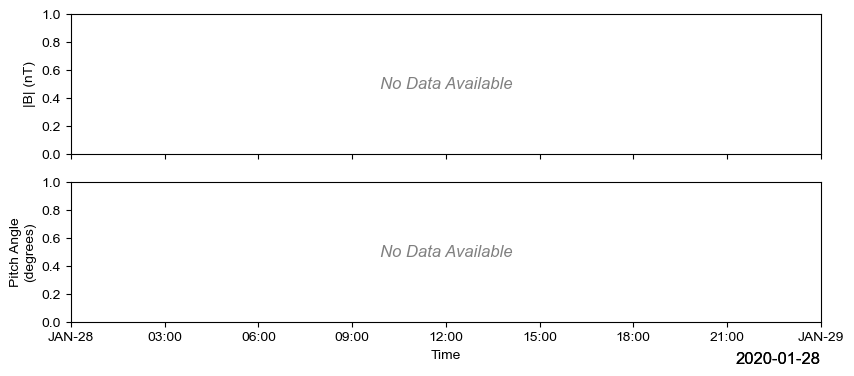

AttributeError: 'NoneType' object has no attribute 'data'

In [ ]:
### Jaye's conjunction jambalaya

conjumble = [['2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02'], #E4
['2020-06-06','2020-06-07','2020-06-08','2020-06-09','2020-06-10'], #E5
['2020-09-25','2020-09-30'], #E6
['2021-01-17','2021-01-19','2021-01-20'], #E7
['2021-04-28','2021-04-29'], #E8gr8
['2021-08-08','2021-08-09','2021-08-10','2021-08-11'], #E9
['2021-11-22'], #E10
['2022-02-25'], #E11
['2022-06-02', '2022-06-03'], #E12
['2022-09-04','2022-09-05','2022-09-06'], #E13
['2022-12-12'], #E14
['2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18'], #E15
['2023-06-21','2023-06-22'], #E16
['2023-09-26', '2023-09-27', '2023-09-28'], #E17
['2023-12-29'], #E18
['2024-03-29', '2024-03-30'], #E19
['2024-06-24','2024-06-25','2024-06-28','2024-06-29','2024-6-30','2024-07-01','2024-07-02','2024-07-03','2024-07-04'], #E20
['2024-09-26','2024-09-28','2024-09-29','2024-09-30','2024-10-01','2024-10-02','2024-10-04'], #E21
['2024-12-23','2024-12-24','2024-12-25'], #E22
['2025-03,19','2025-03-21','2025-03-22','2025-03-23','2025-03-27','2025-03-28'] #E23
]

## 1. Get set of days associated with each encounter
for enc in conjumble:
    for i in range(len(enc)):
        date = enc[i]
        y = int(date[0:4])
        m = int(date[5:7])
        d = int(date[8:10])

        y_str = date[0:4]
        m_str = date[5:7]
        d_str = date[8:10]

        y_f = y
        m_f = m
        d_f = d + 1

        yf_str = str(y_f)
        if m_f > 9:
            mf_str = str(m_f)
        else:
            mf_str = '0{}'.format(m_f)
            
        if d_f > 9:
            df_str = str(d_f)
        else:
            df_str = '0{}'.format(d_f)

        # If next day is out of bounds, change days
        if m in [4,6,9,11]:
            if d == 30:
                m_f += 1
                d_f = 1
                yf_str = str(y_f)
                if m_f > 9:
                    mf_str = str(m_f)
                else:
                    mf_str = '0{}'.format(m_f)
                df_str = '01'

        elif m in [1,2,3,5,7,8,10]:
            if d == 31:
                m_f += 1
                d_f = 1
                yf_str = str(y_f)
                if m_f > 9:
                    mf_str = str(m_f)
                else:
                    mf_str = '0{}'.format(m_f)
                df_str = '01'

        elif m == 12:
            if d == 31:
                y_f += 1
                m_f = 1
                d_f = 1
                yf_str = str(y_f)
                mf_str = '01'
                df_str = '01'
        

        trange = [y_str + '-' + m_str + '-' + d_str + '/00:00:00.000',yf_str +'-' + mf_str + '-' + df_str + '/00:00:00.000']
        plotbot.ploptions.display_figure = True
        # plotbot.ploptions.display_figure = False
        
        plotbot.plotbot(trange,plotbot.mag_rtn_4sa.bmag,1,plotbot.mag_rtn_4sa.br,1,plotbot.epad.strahl,2)

        tpad = np.array(plotbot.epad.datetime_array)
        tB = np.array(plotbot.mag_rtn_4sa.datetime_array)
        epad = 10**np.array(plotbot.epad.strahl.data)
        pangles = np.array(plotbot.epad.pitch_angle_y_values.data)
        Br = np.array(plotbot.mag_rtn_4sa.br.data)
        Bn = np.array(plotbot.mag_rtn_4sa.bn.data)
        phi_B = np.degrees(np.arctan2(Br,Bn)) + 180
        
        ### PLOTBOT IS APPENDING DATA INSTEAD OF REPLACING--WHY?

        ticklocs,ticklabels = tasteful_ticks(tB)

        fig,ax=plt.subplots(1,1,figsize=(10,4))
        ax.scatter(tB,phi_B,s=3)
        ax.set_ylabel(r'$\phi_B \ (\circ) \n$ ')
        ax.set_xticks(ticklocs)
        ax.set_xticklabels(ticklabels)
        
## 2. Input tpad, tB, epad, phi_B into hcs_loc
        hcs_sb,hcs_bounds = hcs_loc(tpad,tB,epad,phi_B,parapar_rats = [1/3,3],beam_bg_rats = [2/3,3/2],return_bounds=True,med_filter_len=49)
        hcs_walls = strahl_walls(epad,pangles,region_inds=hcs_bounds)
        for k in hcs_sb[0]:
            ax.axvline(tpad[k],ls='--',c='k')
        for j in hcs_walls:
            ax.axvspan(tpad[hcs_bounds[j][0]],tpad[hcs_bounds[j][-1]],color='g',alpha=0.1)
        plt.savefig('/Users/sfordin/Documents/Science-Projects/01-psp-wind-conjunction/figures/jaye conjumble/fig phi crossings {}.pdf'.format(date),format='pdf')

